In [1]:
from google.colab import files
file_data = files.upload()

Saving PJM_demand.xlsx to PJM_demand.xlsx


In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from numpy import array
from keras.models import Model
from keras.layers import Input
from keras.layers import RepeatVector, Flatten
from keras.layers import TimeDistributed
from tensorflow.keras.utils import plot_model
from sklearn.metrics import r2_score
from tensorflow import keras
import io
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


In [3]:
load = pd.read_excel(io.BytesIO(file_data['PJM_demand.xlsx']))
load

time  Demand  fiveMinDemand  fiveMinDemandAVG  \
0     2020-04-14 11:00:00   78737          78639           78767.1   
1     2020-04-14 12:00:00   77989          77890           78011.3   
2     2020-04-14 13:00:00   77329          77160           77390.3   
3     2020-04-14 14:00:00   76147          75932           76210.0   
4     2020-04-14 15:00:00   75635          75563           75679.8   
...                   ...     ...            ...               ...   
29203 2023-08-12 15:00:00  121977         122844          121784.3   
29204 2023-08-12 16:00:00  124266         124796          124103.2   
29205 2023-08-12 17:00:00  124890         124974          124976.3   
29206 2023-08-12 18:00:00  123021         122415          123268.4   
29207 2023-08-12 19:00:00  119357         118102          119707.4   

       AnticipatedDemand  Monday  Tuesday  Wednesday  Thursday  Friday  ...  \
0                  78710       0        1          0         0       0  ...   
1                  78010       0        1          0         0       0  ...   
2                  77371       0        1          0         0       0  ...   
3                  76065       0        1          0         0       0  ...   
4                  75367       0        1          0         0       0  ...   
...                  ...     ...      ...        ...       ...     ...  ...   
29203             121796       0        0          0         0       0  ...   
29204             124414       0        0          0         0       0  ...   
29205             125335       0        0          0         0       0  ...   
29206             123089       0        0          0         0       0  ...   
29207             119543       0        0          0         0       0  ...   

       BaltimoreTemp  WashingtonTemp  PhiladelphiaTemp  RichmondTemp  \
0                 53              52                53            55   
1                 56              54                53            57   
2                 57              56                54            59   
3                 58              57                54            61   
4                 58              59                56            62   
...              ...             ...               ...           ...   
29203             92              87                82            93   
29204             91              89                86            91   
29205             90              91                85            90   
29206             90              87                85            91   
29207             89              86                82            87   

       ColombusTemp  ClevelandTemp  PitssburghTemp  DaytonTemp  ChicagoTemp  \
0                41             41              42          41           35   
1                42             43              42          43           36   
2                43             44              43          44           38   
3                45             45              44          44           37   
4                45             45              43          45           39   
...             ...            ...             ...         ...          ...   
29203            87             76              85          89           86   
29204            86             73              83          88           86   
29205            86             74              80          86           87   
29206            86             76              77          85           86   
29207            87             77              72          84           84   

       CincinnatiTemp  
0                  42  
1                  42  
2                  44  
3                  45  
4                  44  
...               ...  
29203              85  
29204              88  
29205              87  
29206              87  
29207              85  

[29208 rows x 23 columns]

In [4]:
load['time'] = pd.to_datetime(load['time'])
load['hour']=load[ "time"].dt.hour
load['DayOfMonth']=load[ "time"].dt.day
load['Month']=load[ "time"].dt.month
load = load.drop(load.columns[0], axis=1)


day_mapping = {
    'Sunday': 1,
    'Monday': 2,
    'Tuesday': 3,
    'Wednesday': 4,
    'Thursday': 5,
    'Friday': 6,
    'Saturday': 7
}

load['day_of_week'] = load.apply(lambda row: next((day_mapping[col] for col in load.columns if row[col] == 1), None), axis=1)

load = load.drop(load.columns[1:11], axis=1)
regions = ['BaltimoreTemp','WashingtonTemp', 'PhiladelphiaTemp','RichmondTemp',
         'ColombusTemp', 'ClevelandTemp', 'PitssburghTemp', 'DaytonTemp',
         'ChicagoTemp','CincinnatiTemp']
load['max_temperature'] = load[regions].max(axis=1)
load['min_temperature'] = load[regions].min(axis=1)
#load['avg_temperature'] = load[regions].mean(axis=1)

load['next_BaltimoreTemp'] = load['BaltimoreTemp'].shift(-1)
load['next_WashingtonTemp'] = load['WashingtonTemp'].shift(-1)
load['next_PhiladelphiaTemp'] = load['PhiladelphiaTemp'].shift(-1)
load['next_RichmondTemp'] = load['RichmondTemp'].shift(-1)
load['next_ColombusTemp'] = load['ColombusTemp'].shift(-1)
load['next_ClevelandTemp'] = load['ClevelandTemp'].shift(-1)
load['next_PitssburghTemp'] = load['PitssburghTemp'].shift(-1)
load['next_DaytonTemp'] = load['DaytonTemp'].shift(-1)
load['next_ChicagoTemp'] = load['ChicagoTemp'].shift(-1)
load['next_CincinnatiTemp'] = load['CincinnatiTemp'].shift(-1)

regions_future = ['next_BaltimoreTemp','next_WashingtonTemp', 'next_PhiladelphiaTemp','next_RichmondTemp',
         'next_ColombusTemp', 'next_ClevelandTemp', 'next_PitssburghTemp', 'next_DaytonTemp',
         'next_ChicagoTemp','next_CincinnatiTemp']
load['next_max_temperature'] = load[regions_future].max(axis=1)
#load['next_min_temperature'] = load[regions_future].min(axis=1)
#load['next_avg_temperature'] = load[regions_future].mean(axis=1)
load.dropna(inplace = True)



In [5]:
values = load.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)



n_features = load.shape[1]

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df =pd.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
     cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
     # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
     cols.append(df.shift(-i))
     if i == 0:
         names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
     else:
             names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
     agg.dropna(inplace=True)
 return agg
# frame as supervised learning

historical_time_step = 24
horizon = 24
reframed = series_to_supervised(scaled,historical_time_step, horizon)

for i in range (n_features-1):
    reframed.drop(reframed.columns[(historical_time_step*n_features)+1+i:(historical_time_step*n_features)+n_features+i],
                  axis=1, inplace=True)


n_train_hours = 23829 - historical_time_step #it means whole 2023 is for the test
print(n_train_hours)

values = reframed.values
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

n_features = load.shape[1]
# split into input and outputs
n_obs = historical_time_step * n_features
train_X, train_y = train[:, :n_obs], train[:, -horizon:]
test_X, test_y = test[:, :n_obs], test[:, -horizon:]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], historical_time_step, n_features))
test_X = test_X.reshape((test_X.shape[0], historical_time_step, n_features))

# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape,)
# plt.plot(load.values[:,0])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


23805
(23805, 24, 29) (23805, 24) (5355, 24, 29) (5355, 24)


In [27]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

# Define model checkpoint callback to save the best weights
model_checkpoint = ModelCheckpoint('best_weights.keras', monitor='prediction_output_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='prediction_output_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


def custom_loss_forecast(y_true, y_pred):
    # apply any custom operation
    return 100 * tf.keras.losses.MeanSquaredError()(y_true, y_pred)

loss_weights = {
    'reconstruction_output': 1.0,  # weight for regression loss
    'prediction_output': 2.0  # weight for classification loss
}
# Define an input sequence and process it.
encoder_inputs = Input(shape=(historical_time_step, n_features))
encoder = LSTM(50, return_state=True, name = "encoder")
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = RepeatVector(historical_time_step)(encoder_states[0])
reconstruction_decoder = LSTM(50, return_sequences=True, return_state=True, name = "reconstruction_decoder")
reconstruction_outputs, _, _ = reconstruction_decoder(decoder_inputs, initial_state=encoder_states)
reconstruction_outputs = Dense(n_features,name = 'reconstruction_output')(reconstruction_outputs)

prediction_decoder = LSTM(50, return_sequences=True, return_state=True, name="prediction_decoder")
prediction_sequence, _, _ = prediction_decoder(encoder_inputs, initial_state=encoder_states)

flattened_prediction = Flatten()(prediction_sequence)
prediction_outputs = Dense(horizon, name='prediction_output')(flattened_prediction)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model(encoder_inputs, [reconstruction_outputs, prediction_outputs])


model.compile(optimizer='adam',
              loss={'reconstruction_output': custom_loss_forecast, 'prediction_output': custom_loss_forecast}
              ,loss_weights=loss_weights)
model.summary()
plot_model(model, show_shapes=True)

split_idx = int(len(train_X) * 0.8)
val_X, val_y = train_X[split_idx:], train_y[split_idx:]
train_X, train_y = train_X[:split_idx], train_y[:split_idx]
# fit network
history = model.fit(train_X, [train_X, train_y], validation_data=(val_X, [val_X, val_y]),
                    epochs=400, batch_size=512,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], verbose=1, shuffle=False)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 24, 29)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (LSTM)            │ [(None, 50), (None,    │         16,000 │ input_layer_9[0][0]    │
│                           │ 50), (None, 50)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_1           │ (None, 24, 50)         │              0 │ encoder[0][1]          │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ prediction_decoder (LSTM) │ [(None, 24, 50),       │         16,000 │ input_layer_9[0][0],   │
│                           │ (None, 50), (None,     │                │ encoder[0][1],         │
│                           │ 50)]                   │                │ encoder[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reconstruction_decoder    │ [(None, 24, 50),       │         20,200 │ repeat_vector_1[0][0], │
│ (LSTM)                    │ (None, 50), (None,     │                │ encoder[0][1],         │
│                           │ 50)]                   │                │ encoder[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 1200)           │              0 │ prediction_decoder[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reconstruction_output     │ (None, 24, 29)         │          1,479 │ reconstruction_decode… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ prediction_output (Dense) │ (None, 24)             │         28,824 │ flatten_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 82,503 (322.28 KB)

 Trainable params: 82,503 (322.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 89.9635 - prediction_output_loss: 19.8179 - reconstruction_output_loss: 70.1456
Epoch 1: prediction_output_loss improved from inf to 19.81794, saving model to best_weights.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 89.9635 - prediction_output_loss: 19.8179 - reconstruction_output_loss: 70.1456 - val_loss: 64.8600 - val_prediction_output_loss: 8.7725 - val_reconstruction_output_loss: 56.0875 - learning_rate: 0.0010
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 69.8514 - prediction_output_loss: 8.4522 - reconstruction_output_loss: 61.3993
Epoch 2: prediction_output_loss improved from 19.81794 to 8.45217, saving model to best_weights.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 69.8514 - prediction_output_loss: 8.4522 - reconstruction_output_loss: 61.3993 - val_loss: 53.7040 - val_prediction_output_loss: 4.4018 - val_reconstruction_output_loss: 49.3022 - learning_rate: 0.0010
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━

In [ ]:
print(history.history.keys())


dict_keys(['loss', 'prediction_output_loss', 'reconstruction_output_loss', 'val_loss', 'val_prediction_output_loss', 'val_reconstruction_output_loss', 'learning_rate'])


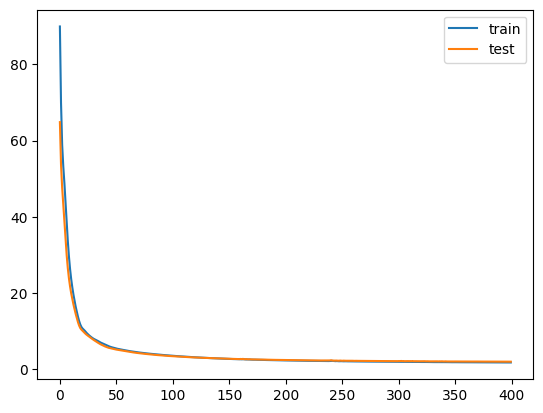

168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test mape: 5.785
Test RMSE: 6803.425
Test mae: 5127.373
Test r2: 0.776
Error for forecast step number 1: rmse :4844.72,mape :4.29, mae :3746.65, r2 :0.89
Error for forecast step number 2: rmse :5442.19,mape :4.81, mae :4222.60, r2 :0.86
Error for forecast step number 3: rmse :5588.02,mape :4.99, mae :4361.62, r2 :0.85
Error for forecast step number 4: rmse :6164.67,mape :5.48, mae :4791.27, r2 :0.82
Error for forecast step number 5: rmse :6235.29,mape :5.44, mae :4781.71, r2 :0.81
Error for forecast step number 6: rmse :5789.10,mape :5.02, mae :4414.70, r2 :0.84
Error for forecast step number 7: rmse :6138.16,mape :5.25, mae :4640.82, r2 :0.82
Error for forecast step number 8: rmse :6500.81,mape :5.54, mae :4890.63, r2 :0.80
Error for forecast step number 9: rmse :7143.75,mape :5.89, mae :5217.85, r2 :0.75
Error for forecast step number 10: rmse :6503.19,mape :5.58, mae :4928.00, r2 :0.80
Error for forecast step number 11: rmse :6779.68,mape :5.

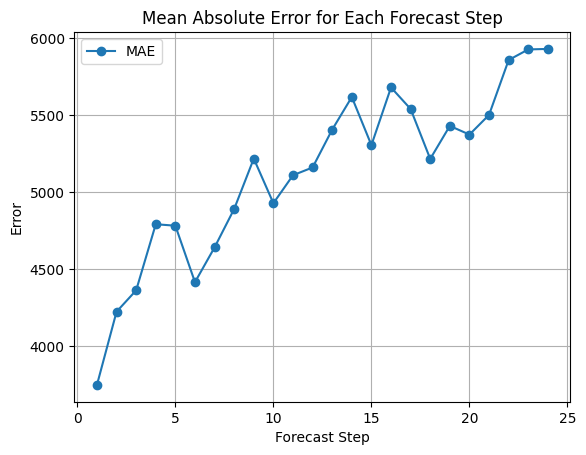

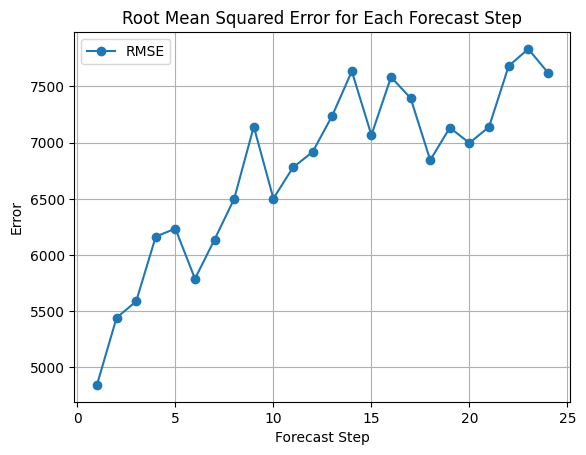

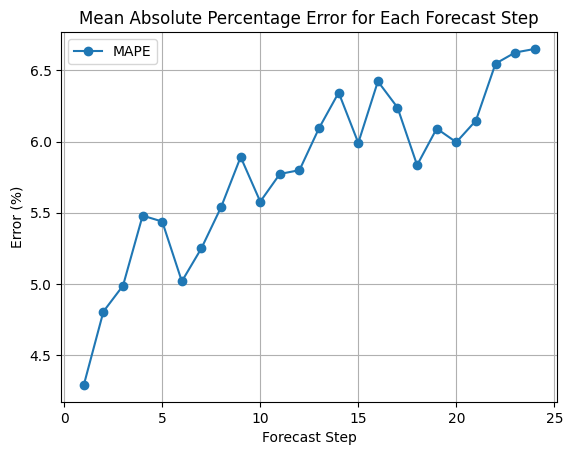

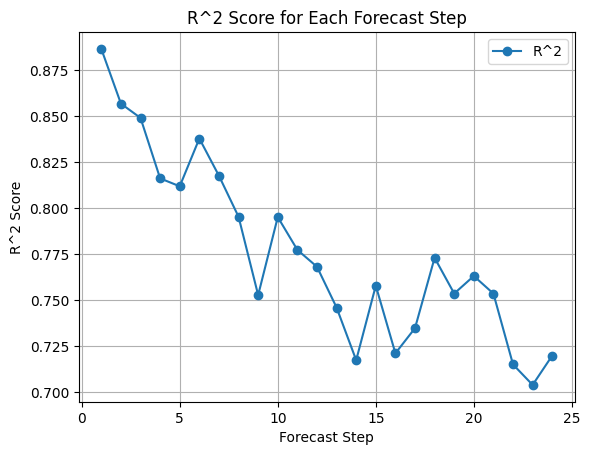

In [28]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


# make a prediction
yhat = model.predict(test_X)
yhat_forecast = yhat[1]
def invert_scaling_multistep(predictions, scaler, feature_index):
    """
    Invert the scaling for a multistep prediction.

    predictions: The predicted values to invert.
    scaler: The scaler object that was originally fitted to the dataset.
    feature_index: The index of the feature in the original dataset that you're predicting.
    """
    # Extract the min and scale values for the feature of interest from the scaler
    min_val = scaler.data_min_[feature_index]
    scale = scaler.scale_[feature_index]

    # Invert the scaling
    inverted = predictions / scale + min_val
    return inverted
feature_index = 0
yhat_original = invert_scaling_multistep(yhat_forecast, scaler, feature_index)
test_y_original = invert_scaling_multistep(test_y, scaler, feature_index)

rmse = sqrt(mean_squared_error(test_y_original, yhat_original))
mape = 100*mean_absolute_percentage_error(test_y_original, yhat_original)
mae = mean_absolute_error(test_y_original, yhat_original)
r2 = r2_score(test_y_original, yhat_original)

print('Test mape: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)
print('Test mae: %.3f' % mae)
print('Test r2: %.3f' % r2)




maes = []
rmses = []
mapes = []
r2s = []
# Loop through each forecast step
for i in range(horizon):
    mae = mean_absolute_error(test_y_original[:, i], yhat_original[:, i])
    rmse = sqrt(mean_squared_error(test_y_original[:, i], yhat_original[:, i]))
    mape = 100*mean_absolute_percentage_error(test_y_original[:, i], yhat_original[:, i])
    r2 = r2_score(test_y_original[:, i], yhat_original[:, i])
    maes.append(mae)
    rmses.append(rmse)
    mapes.append(mape)
    r2s.append(r2)
    print(f"Error for forecast step number {i+1}: rmse :{rmse:.2f},mape :{mape:.2f}, mae :{mae:.2f}, r2 :{r2:.2f}")

from sklearn.metrics import precision_score, recall_score

# Convert test_y_original and yhat_original to DataFrames
test_y_original_df = pd.DataFrame(test_y_original)
yhat_original_df = pd.DataFrame(yhat_original)

n_steps = test_y_original_df.shape[1]
forecast_steps = [i+1 for i in range(horizon)]


# Plot MAE
plt.figure()
plt.plot(forecast_steps, maes, marker='o', label='MAE')
plt.title('Mean Absolute Error for Each Forecast Step')
plt.xlabel('Forecast Step')
plt.ylabel('Error')
plt.grid(True)
plt.legend()
plt.show()

# Plot RMSE
plt.figure()
plt.plot(forecast_steps, rmses, marker='o', label='RMSE')
plt.title('Root Mean Squared Error for Each Forecast Step')
plt.xlabel('Forecast Step')
plt.ylabel('Error')
plt.grid(True)
plt.legend()
plt.show()

# Plot SMAPE
plt.figure()
plt.plot(forecast_steps, mapes, marker='o', label='MAPE')
plt.title('Mean Absolute Percentage Error for Each Forecast Step')
plt.xlabel('Forecast Step')
plt.ylabel('Error (%)')
plt.grid(True)
plt.legend()
plt.show()

# Plot R^2
plt.figure()
plt.plot(forecast_steps, r2s, marker='o', label='R^2')
plt.title('R^2 Score for Each Forecast Step')
plt.xlabel('Forecast Step')
plt.ylabel('R^2 Score')
plt.grid(True)
plt.legend()
plt.show()



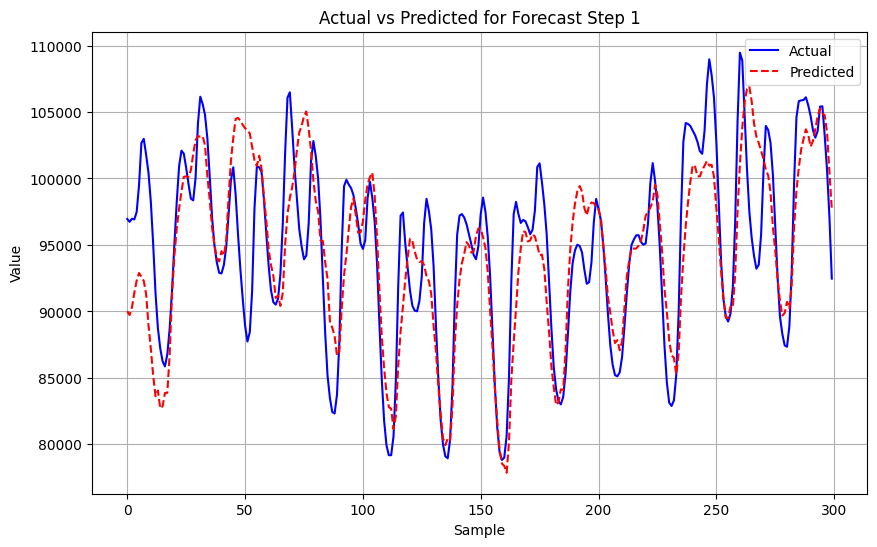

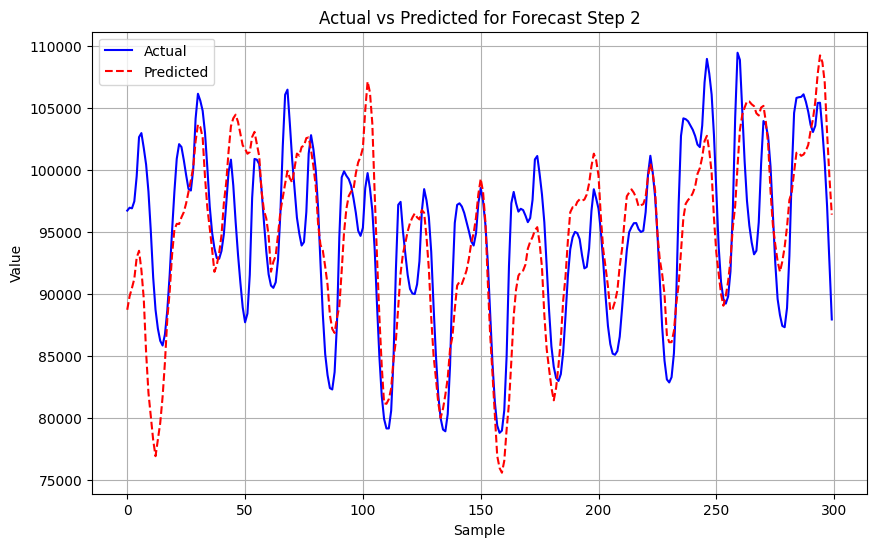

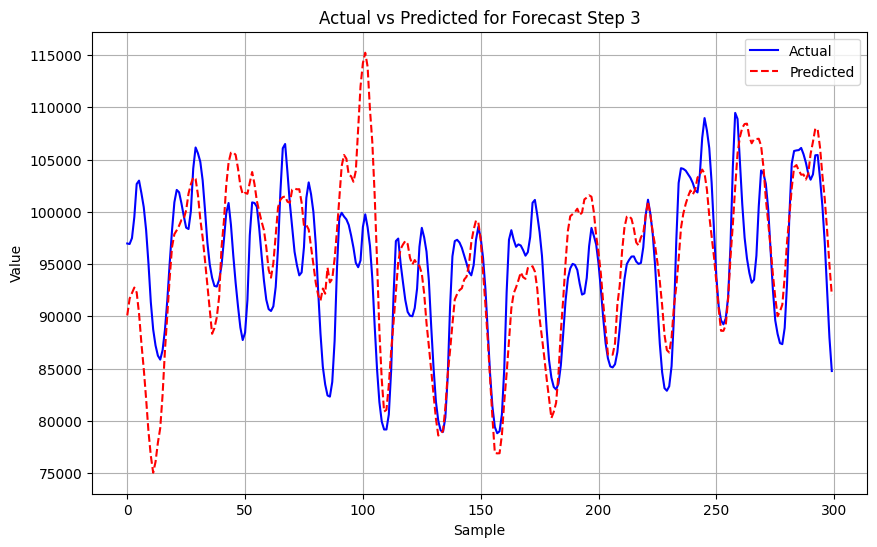

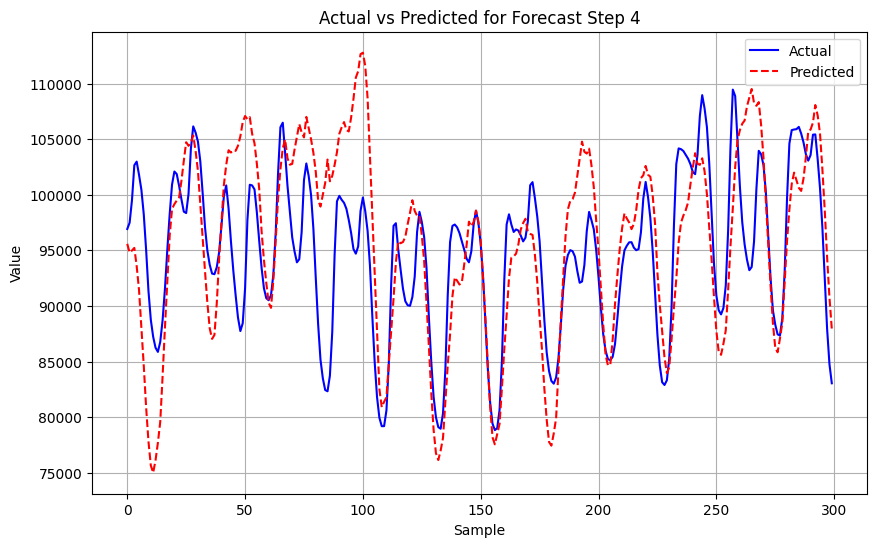

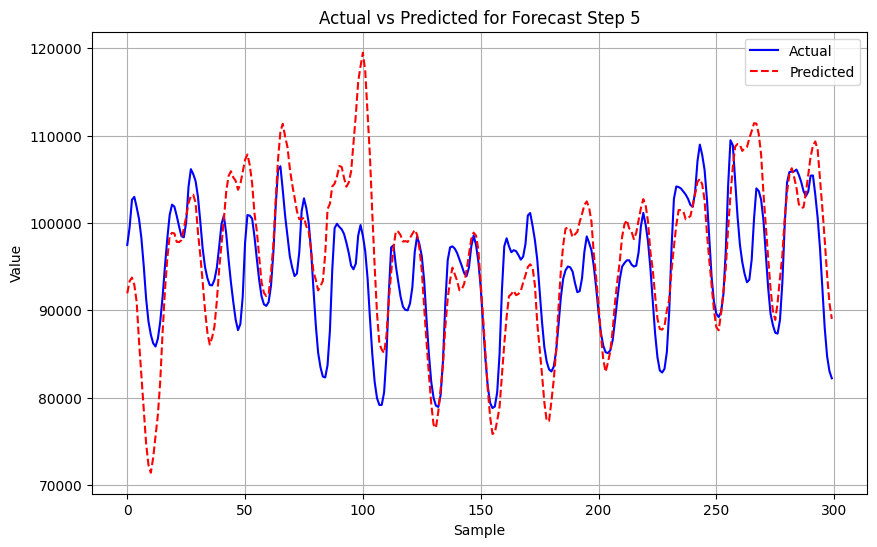

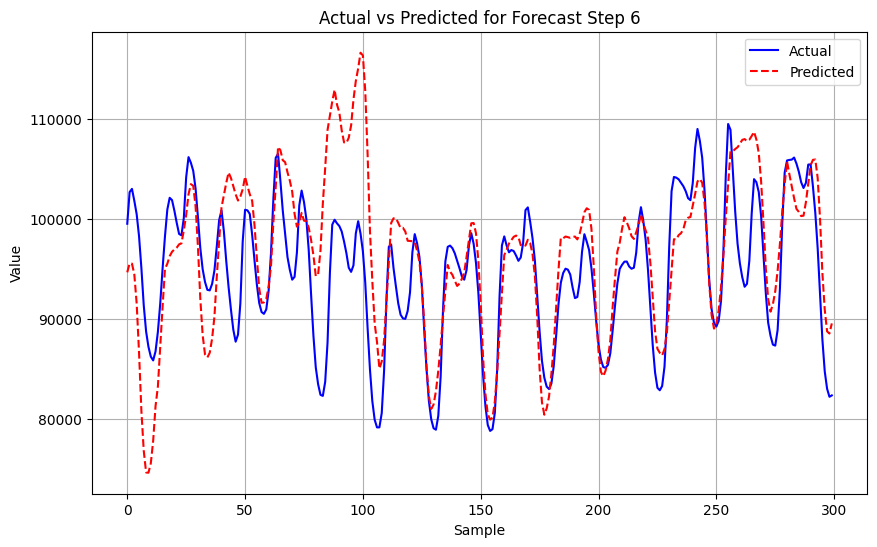

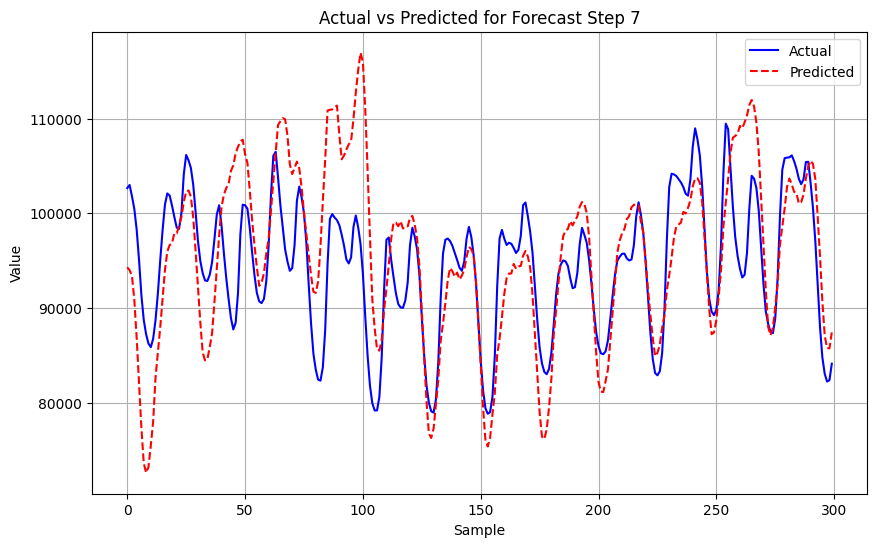

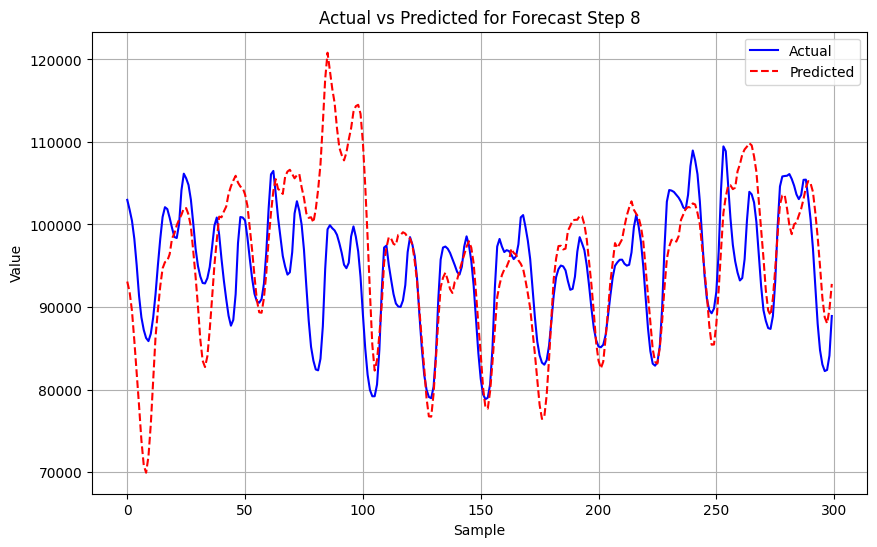

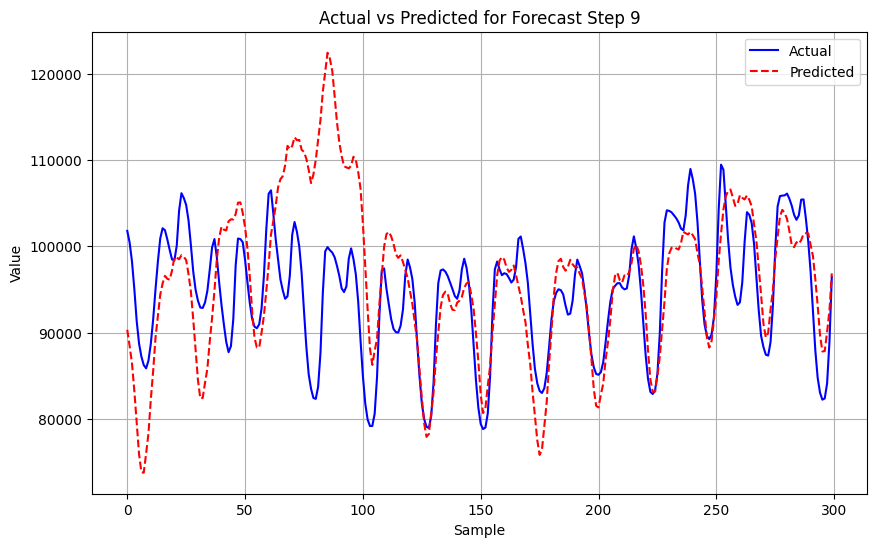

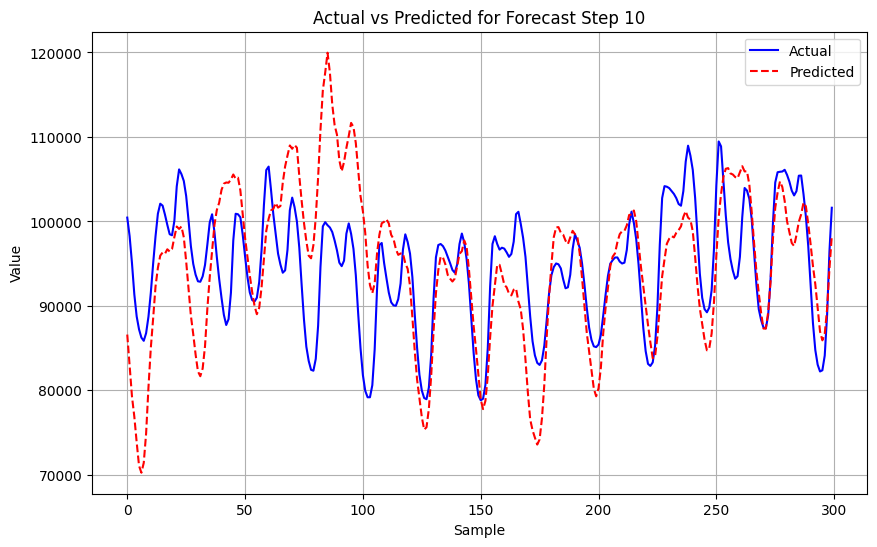

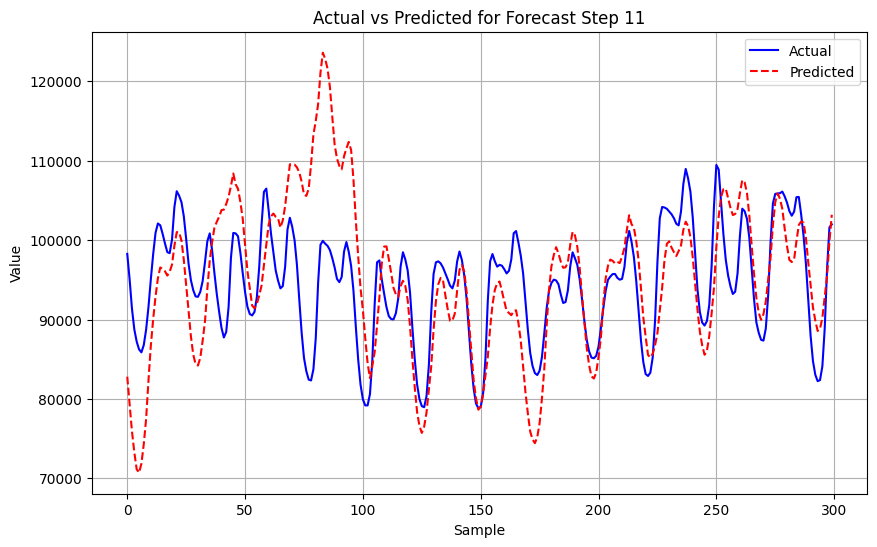

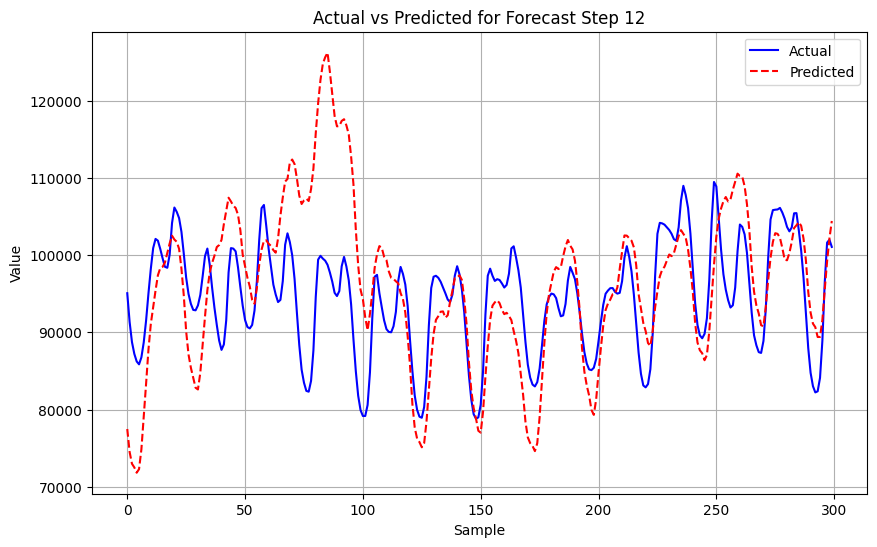

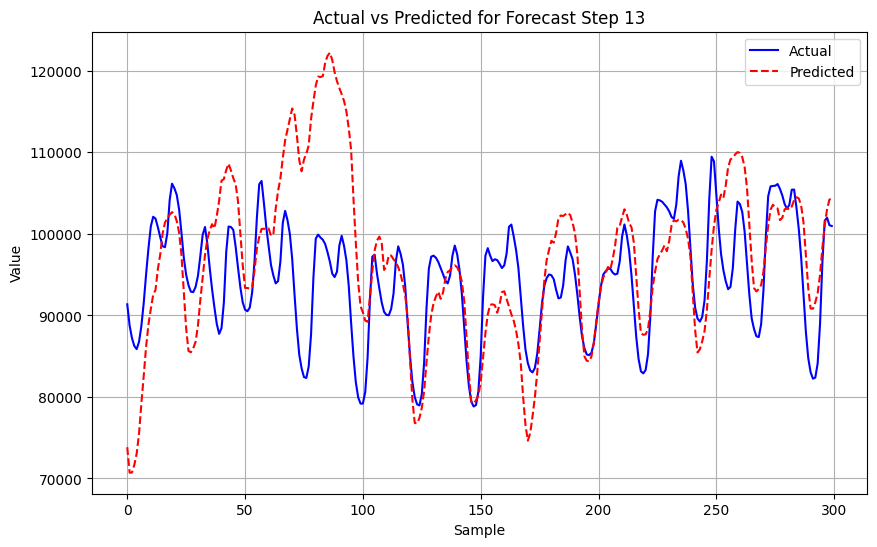

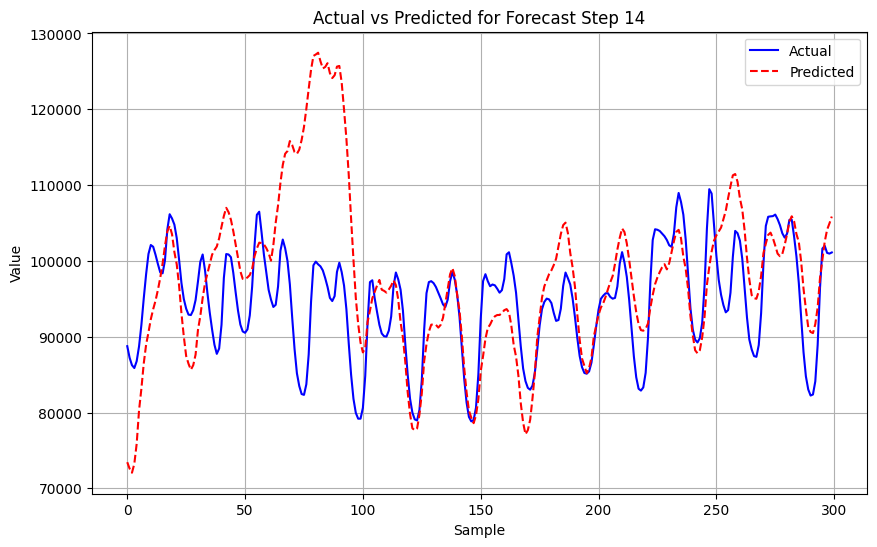

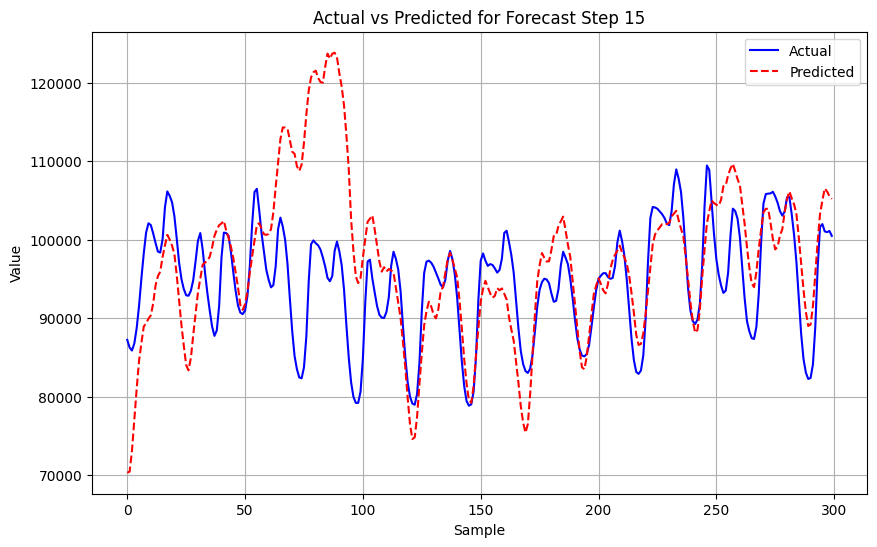

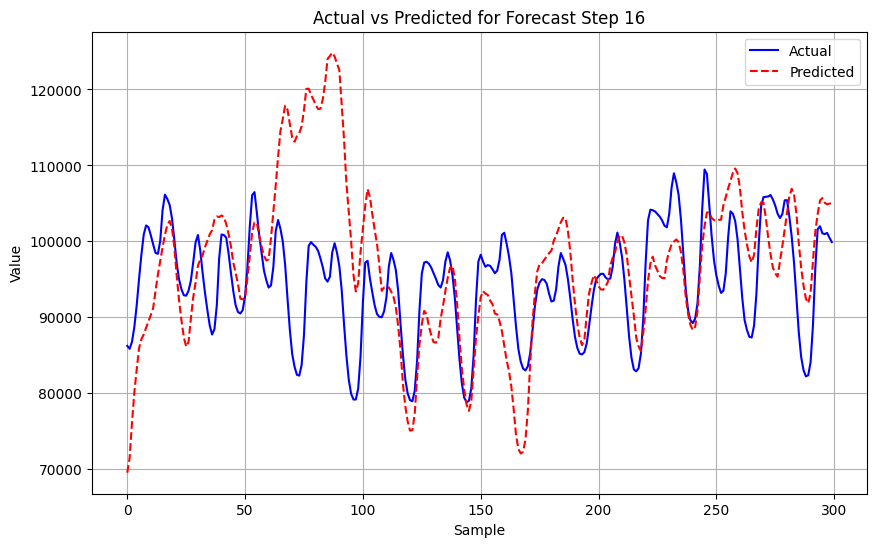

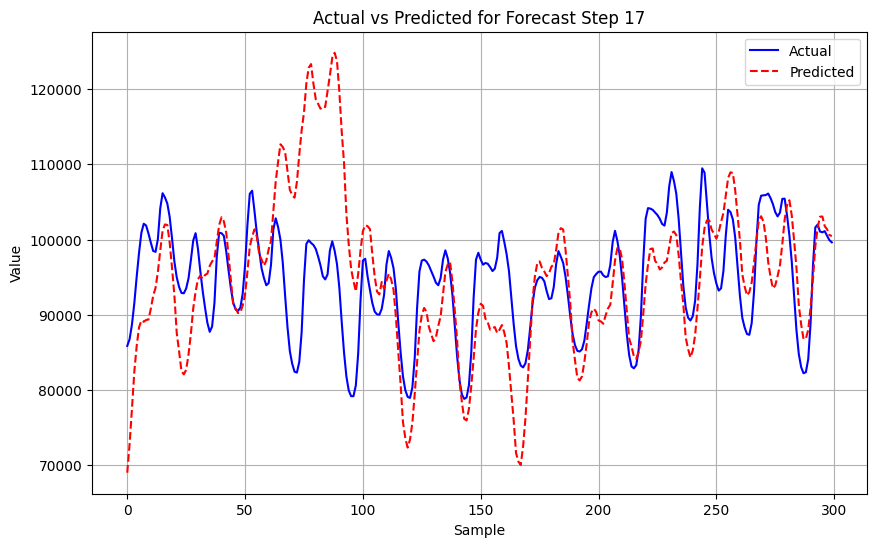

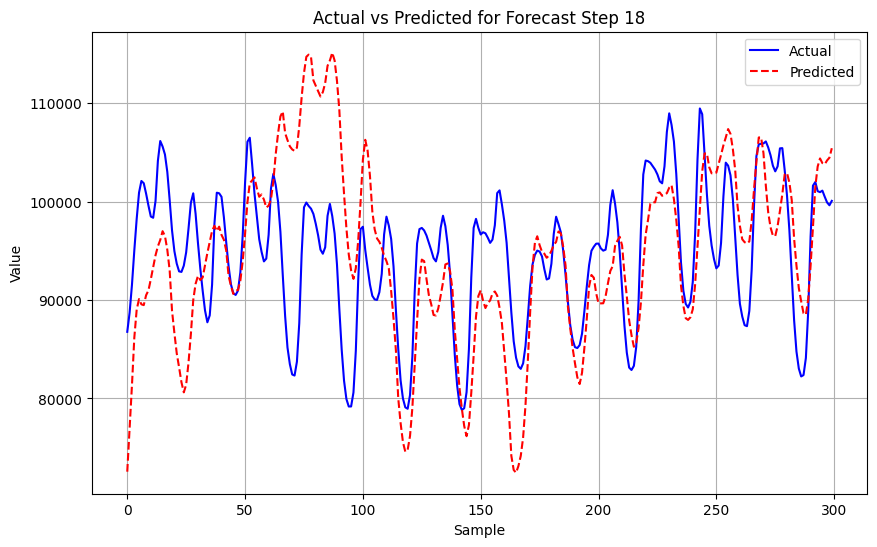

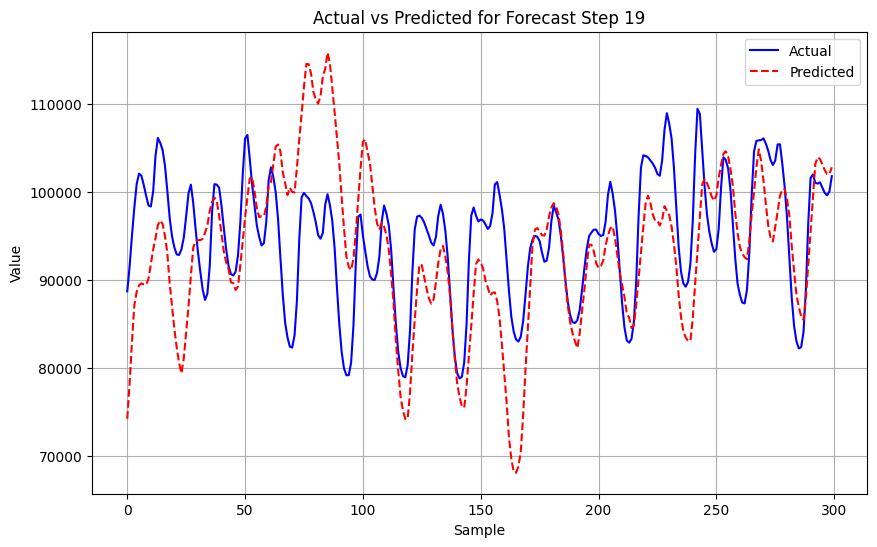

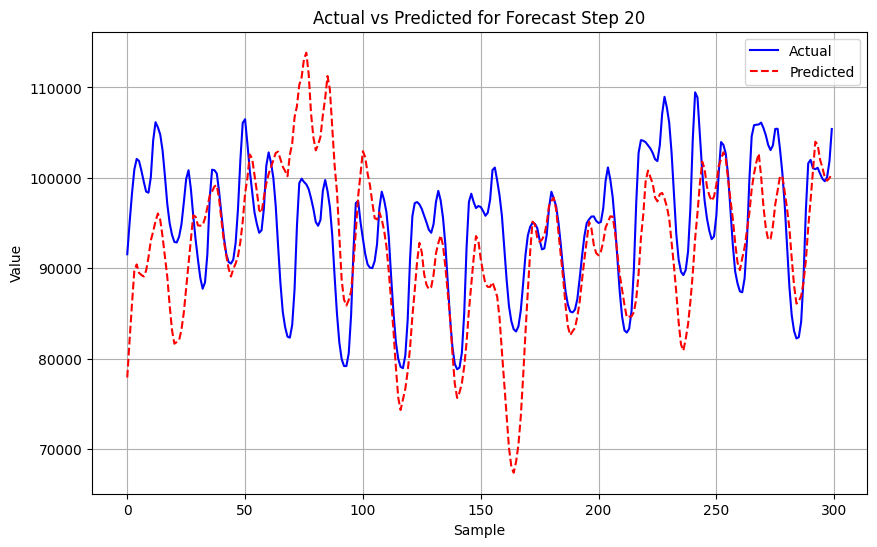

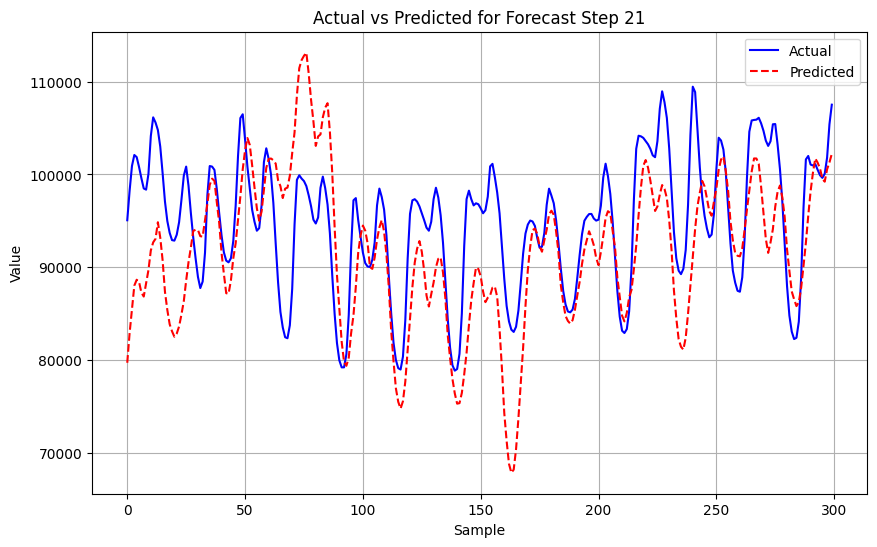

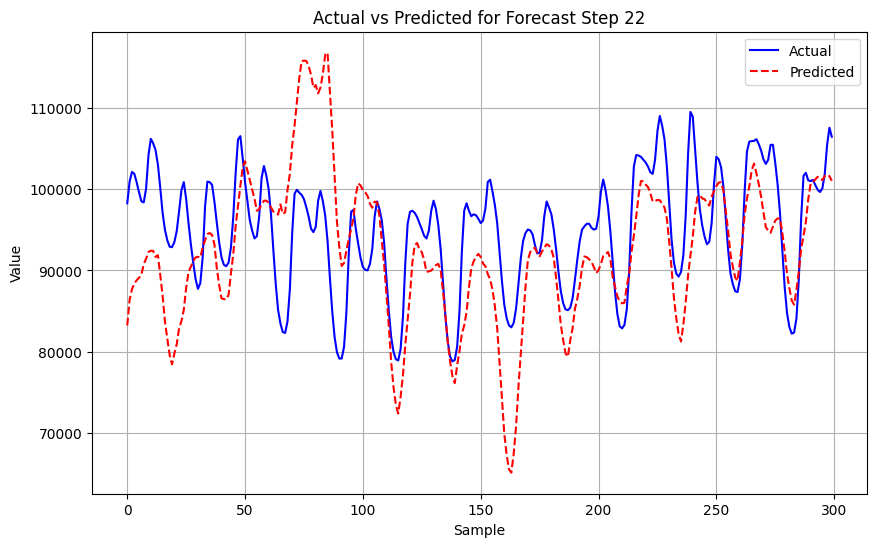

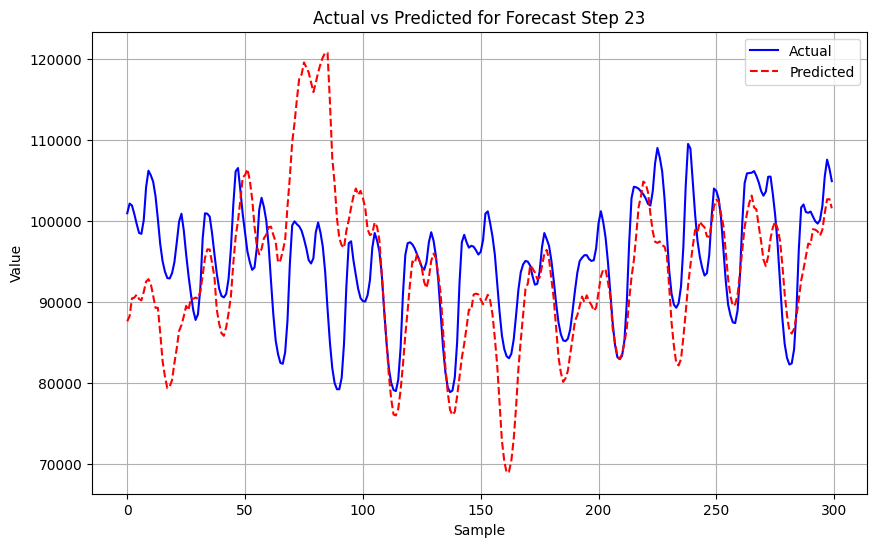

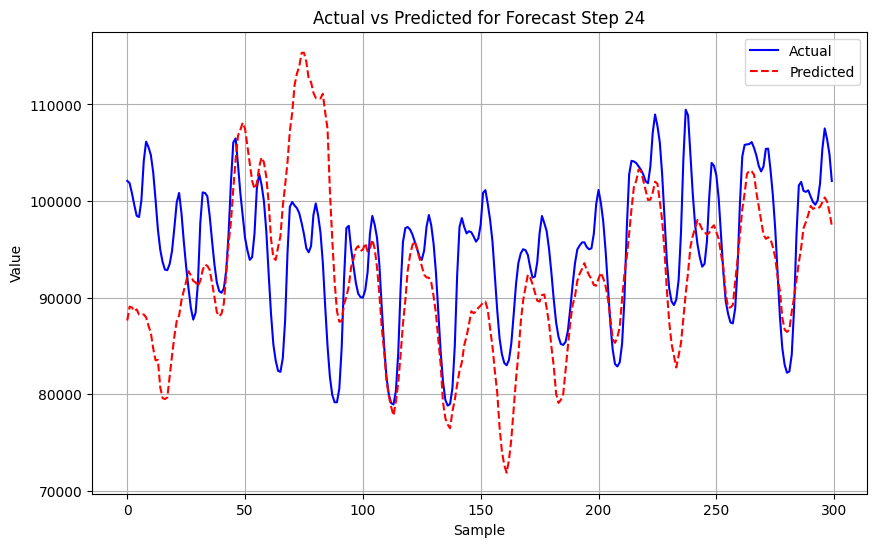

In [29]:
'''
visualization
'''

num_samples = 250

for i in range(horizon):
    plt.figure(figsize=(10, 6))
    plt.plot(test_y_original[300:600, i], label='Actual', color='blue')
    plt.plot(yhat_original[300:600, i], label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted for Forecast Step {i+1}')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


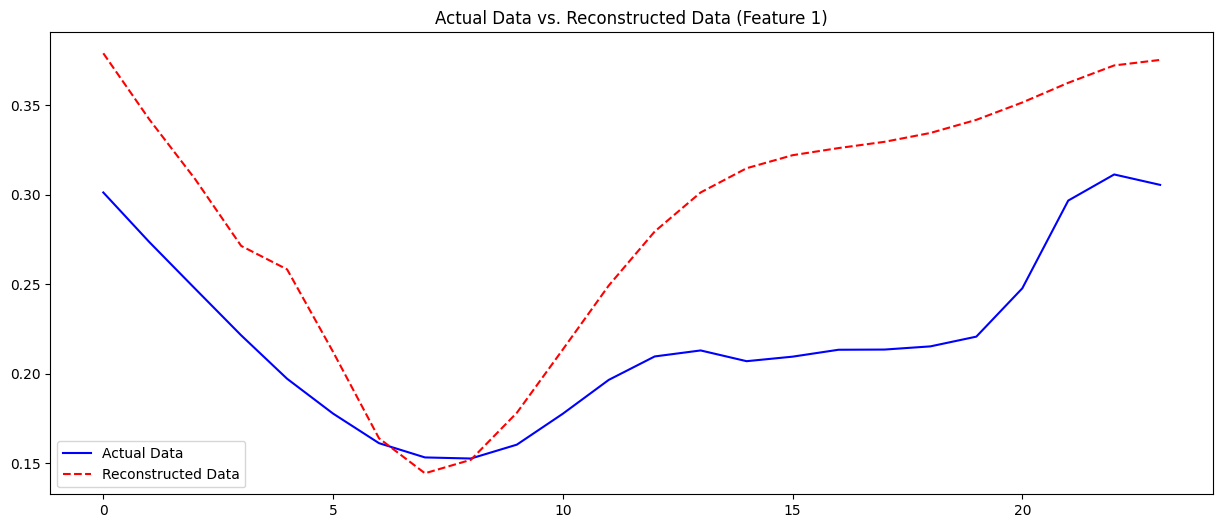

In [ ]:
reconstructed_data, forecasted_data = model.predict(test_X)
index_to_visualize = 20


# Extract the first feature for the specific index
actual_data_feature_1 = test_X[index_to_visualize, :, 0]
reconstructed_data_feature_1 = reconstructed_data[index_to_visualize, :, 0]

plt.figure(figsize=(15, 6))

# Plotting actual data of the first feature
plt.plot(actual_data_feature_1, label='Actual Data', color='blue')

# Plotting reconstructed data of the first feature
plt.plot(reconstructed_data_feature_1, label='Reconstructed Data', color='red', linestyle='--')

plt.title('Actual Data vs. Reconstructed Data (Feature 1)')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2650
Epoch 1: val_loss improved from inf to 0.21915, saving model to best_weights.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2650 - val_loss: 0.2192 - learning_rate: 0.0010
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2230
Epoch 2: val_loss improved from 0.21915 to 0.18651, saving model to best_weights.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.2230 - val_loss: 0.1865 - learning_rate: 0.0010
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1897
Epoch 3: val_loss improved from 0.18651 to 0.16060, saving model to best_weights.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1897 - val_loss: 0.1606 - learning_rate: 0.0010
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1633
Epoch 4: val_loss improved from 0.16060 to 0.13979, saving model to best_weights.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1633 - val_loss: 0.1398 - learning_rate: 0.0010
Epoch 5/400
1/1

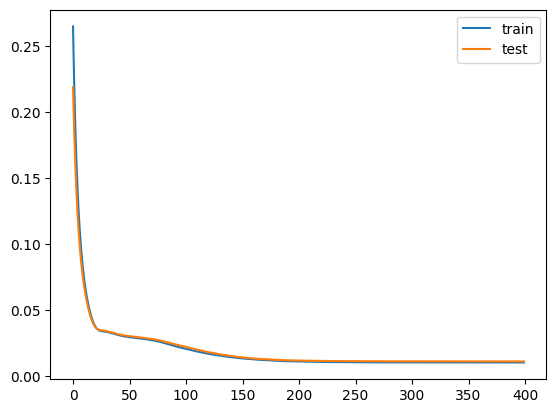

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test mape: 8.697
Test RMSE: 9806.485
Test mae: 7707.660
Test r2: 0.534
Error for forecast step number 1: rmse :9039.30,mape :8.22, mae :7093.26, r2 :0.60
Error for forecast step number 2: rmse :10673.82,mape :9.71, mae :8464.85, r2 :0.45
Error for forecast step number 3: rmse :9686.68,mape :8.57, mae :7469.66, r2 :0.55
Error for forecast step number 4: rmse :10722.63,mape :9.54, mae :8276.70, r2 :0.44
Error for forecast step number 5: rmse :9325.97,mape :8.34, mae :7295.48, r2 :0.58
Error for forecast step number 6: rmse :9514.69,mape :8.68, mae :7553.97, r2 :0.56
Error for forecast step number 7: rmse :8409.03,mape :7.54, mae :6654.37, r2 :0.66
Error for forecast step number 8: rmse :11008.36,mape :9.83, mae :8664.76, r2 :0.41
Error for forecast step number 9: rmse :9422.77,mape :8.29, mae :7386.50, r2 :0.57
Error for forecast step number 10: rmse :11773.31,mape :10.44, mae :9367.85, r2 :0.33
Error for forecast step number 11: rmse :9540.31,map

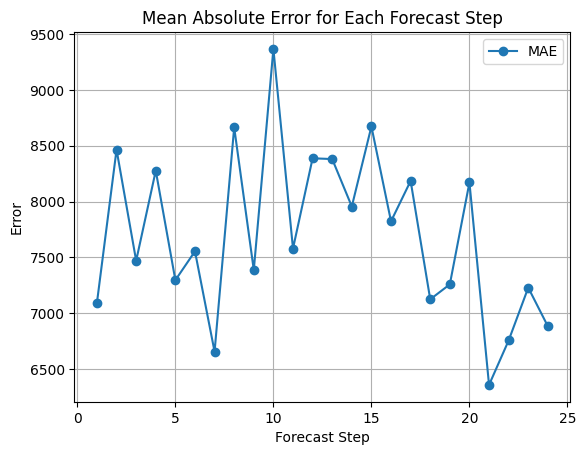

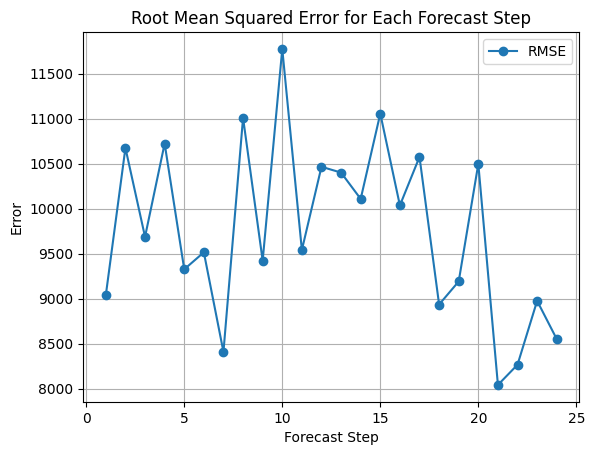

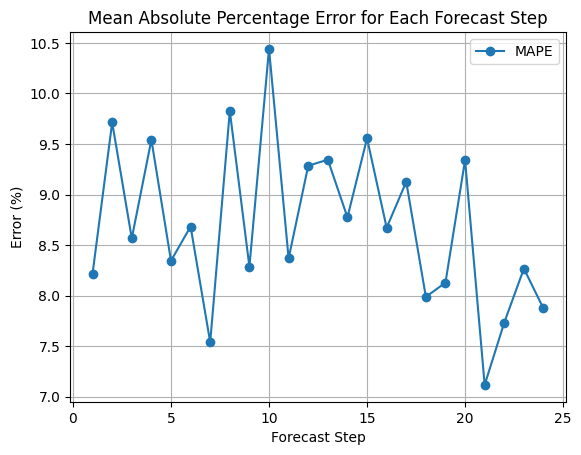

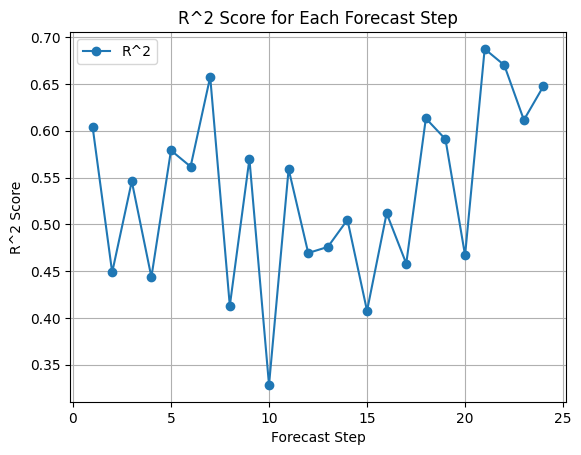

In [23]:
split_idx = int(len(train_X) * 0.8)
val_X, val_y = train_X[split_idx:], train_y[split_idx:]
train_X, train_y = train_X[:split_idx], train_y[:split_idx]

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_weights.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, min_delta=0.001, cooldown=0, min_lr=1e-5)

# Design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='Adam')

# Fit network
history = model.fit(train_X, train_y, epochs=400, batch_size=512,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], validation_data=(val_X, val_y), verbose=1, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


# make a prediction
yhat = model.predict(test_X)

def invert_scaling_multistep(predictions, scaler, feature_index):
    """
    Invert the scaling for a multistep prediction.

    predictions: The predicted values to invert.
    scaler: The scaler object that was originally fitted to the dataset.
    feature_index: The index of the feature in the original dataset that you're predicting.
    """
    # Extract the min and scale values for the feature of interest from the scaler
    min_val = scaler.data_min_[feature_index]
    scale = scaler.scale_[feature_index]

    # Invert the scaling
    inverted = predictions / scale + min_val
    return inverted
feature_index = 0
yhat_original = invert_scaling_multistep(yhat, scaler, feature_index)
test_y_original = invert_scaling_multistep(test_y, scaler, feature_index)

rmse = sqrt(mean_squared_error(test_y_original, yhat_original))
mape = 100*mean_absolute_percentage_error(test_y_original, yhat_original)
mae = mean_absolute_error(test_y_original, yhat_original)
r2 = r2_score(test_y_original, yhat_original)

print('Test mape: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)
print('Test mae: %.3f' % mae)
print('Test r2: %.3f' % r2)

maes = []
rmses = []
mapes = []
r2s = []
# Loop through each forecast step
for i in range(horizon):
    mae = mean_absolute_error(test_y_original[:, i], yhat_original[:, i])
    rmse = sqrt(mean_squared_error(test_y_original[:, i], yhat_original[:, i]))
    mape = 100*mean_absolute_percentage_error(test_y_original[:, i], yhat_original[:, i])
    r2 = r2_score(test_y_original[:, i], yhat_original[:, i])
    maes.append(mae)
    rmses.append(rmse)
    mapes.append(mape)
    r2s.append(r2)
    print(f"Error for forecast step number {i+1}: rmse :{rmse:.2f},mape :{mape:.2f}, mae :{mae:.2f}, r2 :{r2:.2f}")

from sklearn.metrics import precision_score, recall_score

# Convert test_y_original and yhat_original to DataFrames
test_y_original_df = pd.DataFrame(test_y_original)
yhat_original_df = pd.DataFrame(yhat_original)

n_steps = test_y_original_df.shape[1]
forecast_steps = [i+1 for i in range(horizon)]


# Plot MAE
plt.figure()
plt.plot(forecast_steps, maes, marker='o', label='MAE')
plt.title('Mean Absolute Error for Each Forecast Step')
plt.xlabel('Forecast Step')
plt.ylabel('Error')
plt.grid(True)
plt.legend()
plt.show()

# Plot RMSE
plt.figure()
plt.plot(forecast_steps, rmses, marker='o', label='RMSE')
plt.title('Root Mean Squared Error for Each Forecast Step')
plt.xlabel('Forecast Step')
plt.ylabel('Error')
plt.grid(True)
plt.legend()
plt.show()

# Plot SMAPE
plt.figure()
plt.plot(forecast_steps, mapes, marker='o', label='MAPE')
plt.title('Mean Absolute Percentage Error for Each Forecast Step')
plt.xlabel('Forecast Step')
plt.ylabel('Error (%)')
plt.grid(True)
plt.legend()
plt.show()

# Plot R^2
plt.figure()
plt.plot(forecast_steps, r2s, marker='o', label='R^2')
plt.title('R^2 Score for Each Forecast Step')
plt.xlabel('Forecast Step')
plt.ylabel('R^2 Score')
plt.grid(True)
plt.legend()
plt.show()

Epoch 1/400


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - loss: 0.2136
Epoch 1: val_loss improved from inf to 0.14114, saving model to best_weights.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2136 - val_loss: 0.1411 - learning_rate: 0.0010
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1351
Epoch 2: val_loss improved from 0.14114 to 0.09172, saving model to best_weights.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1351 - val_loss: 0.0917 - learning_rate: 0.0010
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0860
Epoch 3: val_loss improved from 0.09172 to 0.06203, saving model to best_weights.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0860 - val_loss: 0.0620 - learning_rate: 0.0010
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0573
Epoch 4: val_loss improved from 0.06203 to 0.04822, saving model to best_weights.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0573 - val_loss: 0.0482 - learning_rate: 0.0010
Epoch 5/400
1/1 ━━━━━━━━

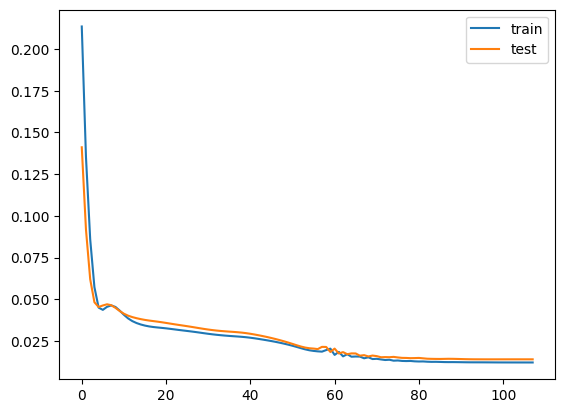

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test mape: 9.000
Test RMSE: 10279.201
Test mae: 7960.058
Test r2: 0.489
Error for forecast step number 1: rmse :10565.77,mape :9.63, mae :8238.18, r2 :0.46
Error for forecast step number 2: rmse :10315.53,mape :9.20, mae :7944.36, r2 :0.49
Error for forecast step number 3: rmse :10447.33,mape :9.33, mae :7986.31, r2 :0.47
Error for forecast step number 4: rmse :10646.74,mape :9.49, mae :8053.66, r2 :0.45
Error for forecast step number 5: rmse :9922.99,mape :8.78, mae :7546.87, r2 :0.52
Error for forecast step number 6: rmse :10594.20,mape :9.40, mae :8183.97, r2 :0.46
Error for forecast step number 7: rmse :10922.93,mape :9.76, mae :8459.56, r2 :0.42
Error for forecast step number 8: rmse :9841.63,mape :8.87, mae :7751.09, r2 :0.53
Error for forecast step number 9: rmse :9690.27,mape :8.71, mae :7656.72, r2 :0.55
Error for forecast step number 10: rmse :10073.24,mape :9.11, mae :8011.87, r2 :0.51
Error for forecast step number 11: rmse :10232.92

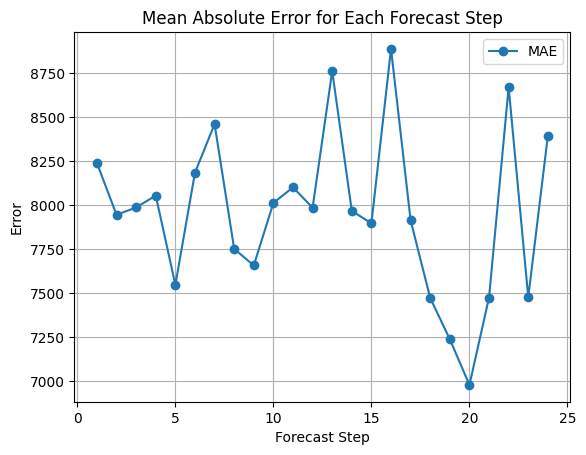

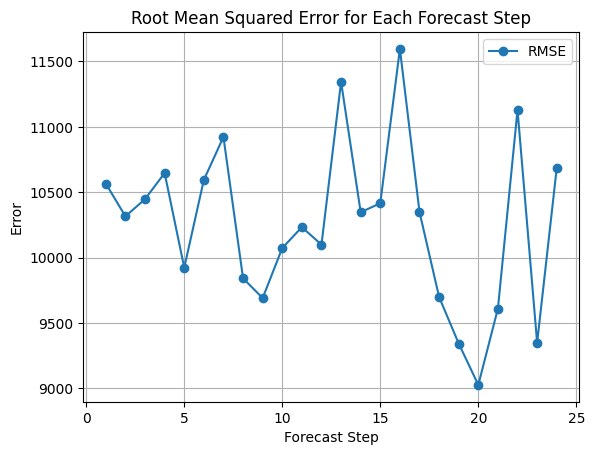

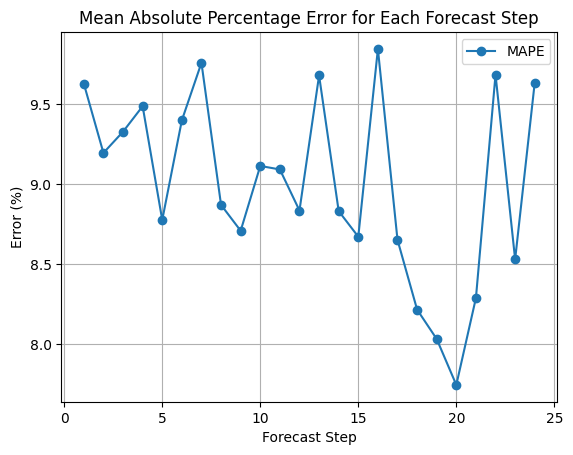

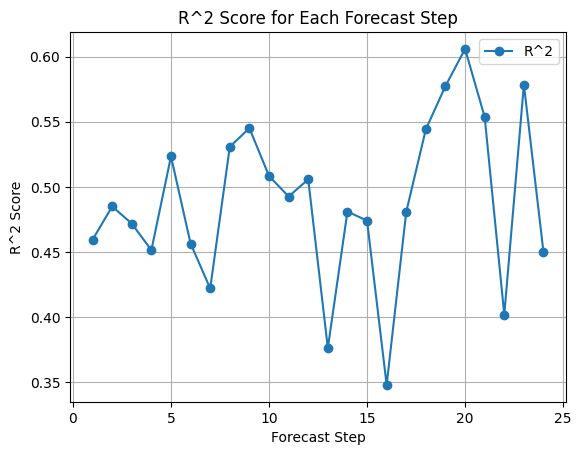

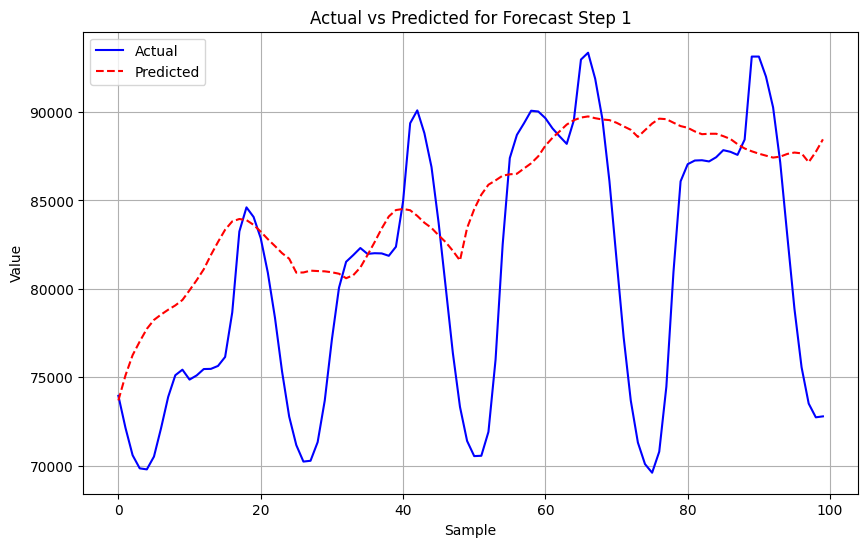

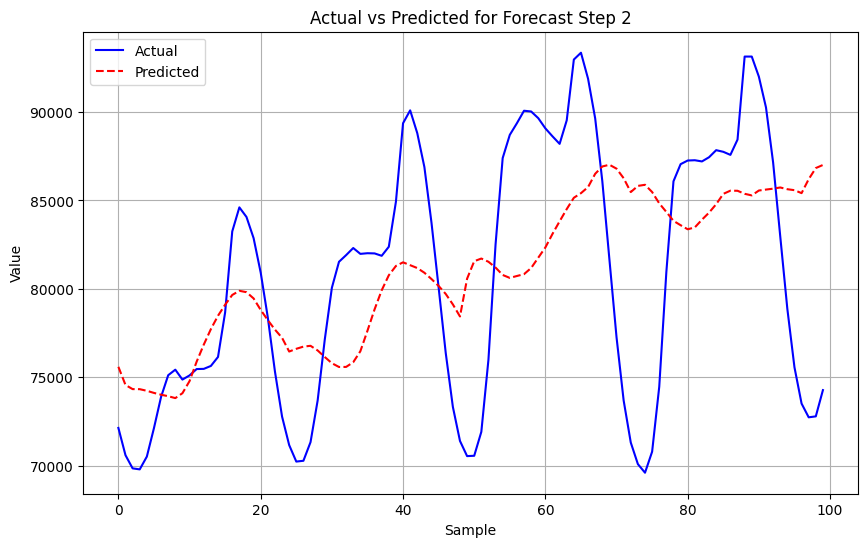

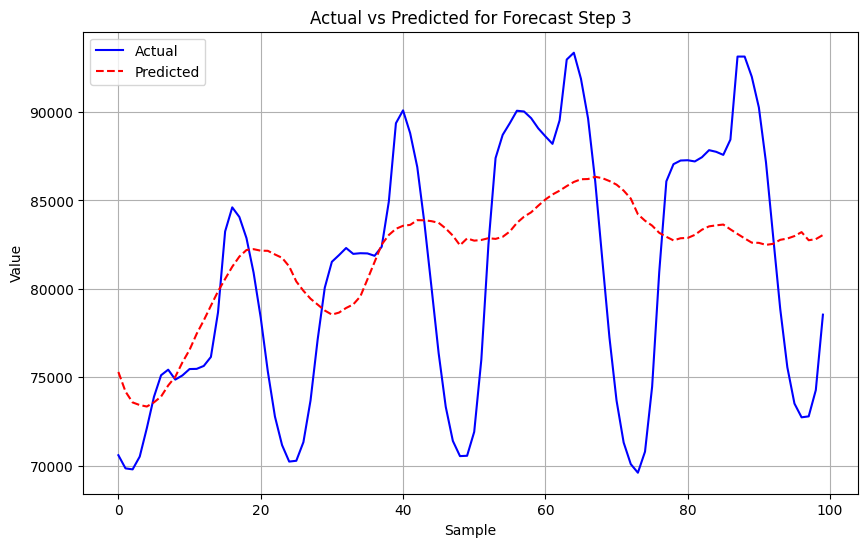

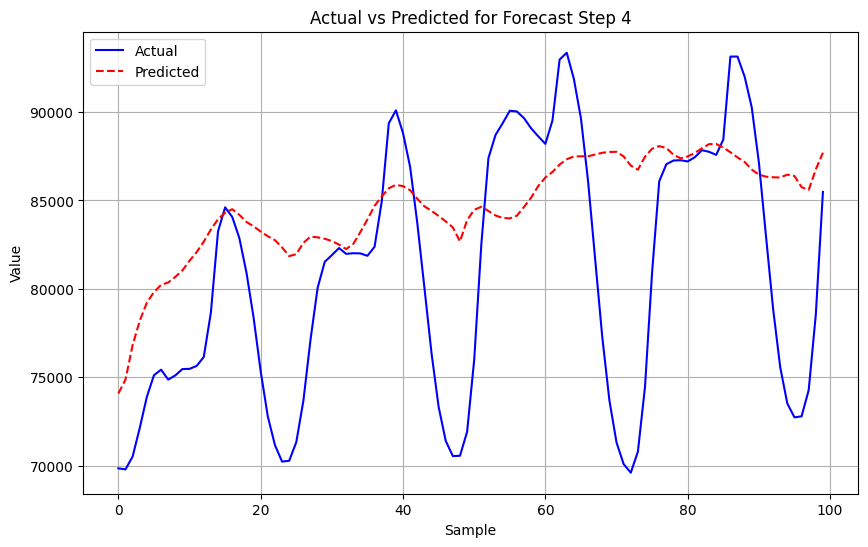

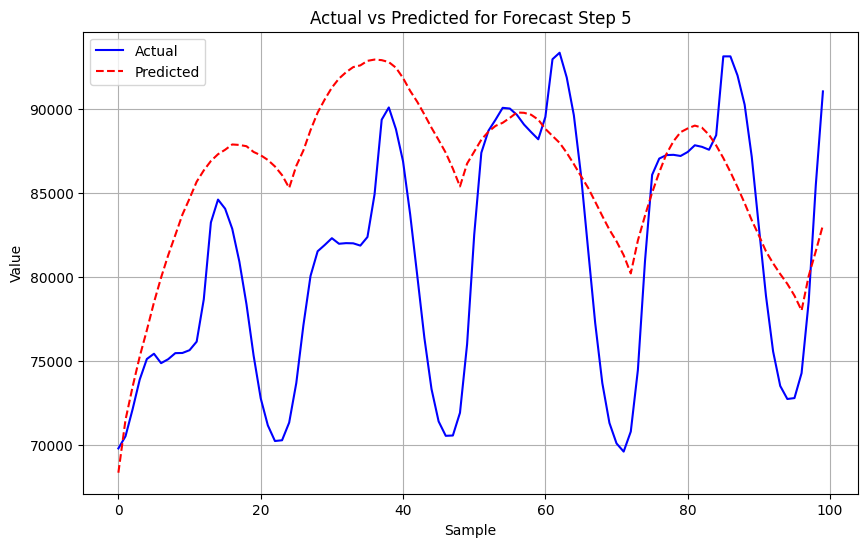

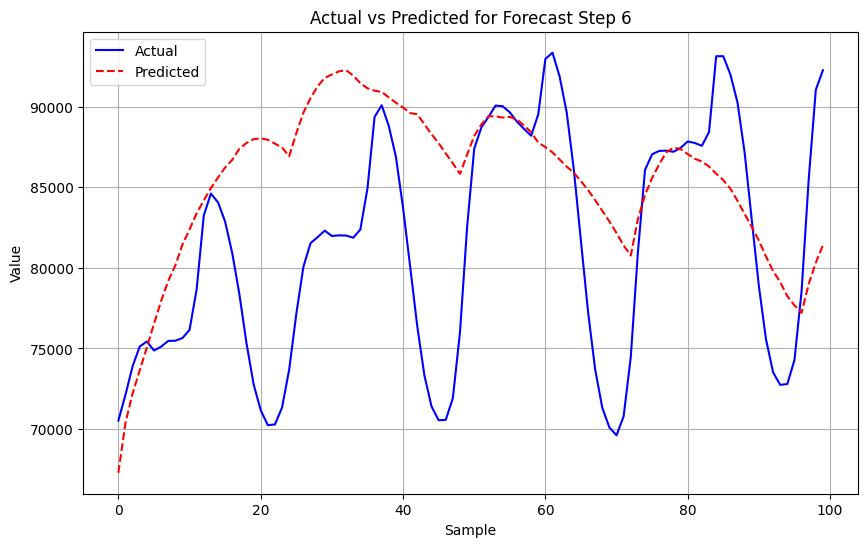

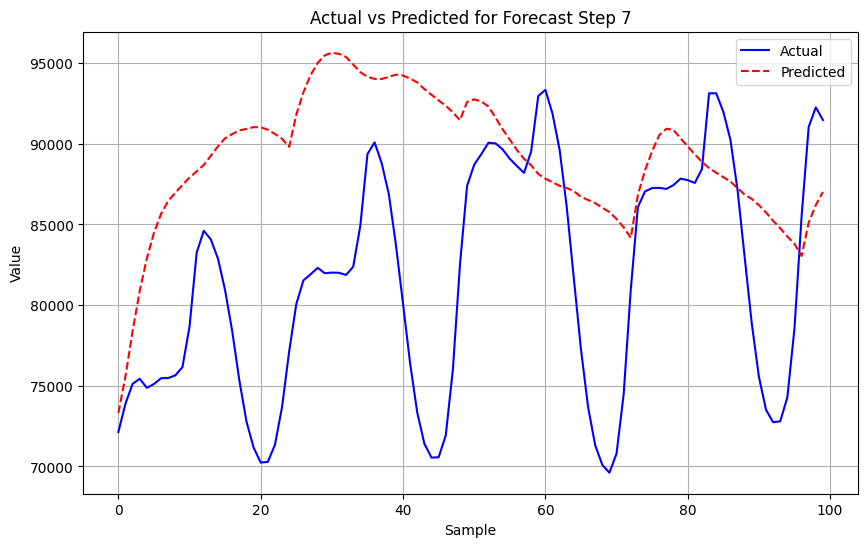

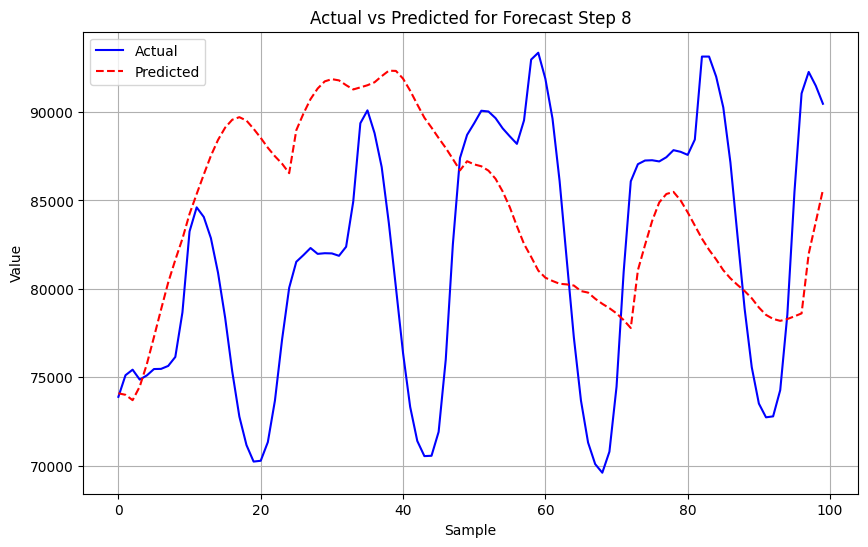

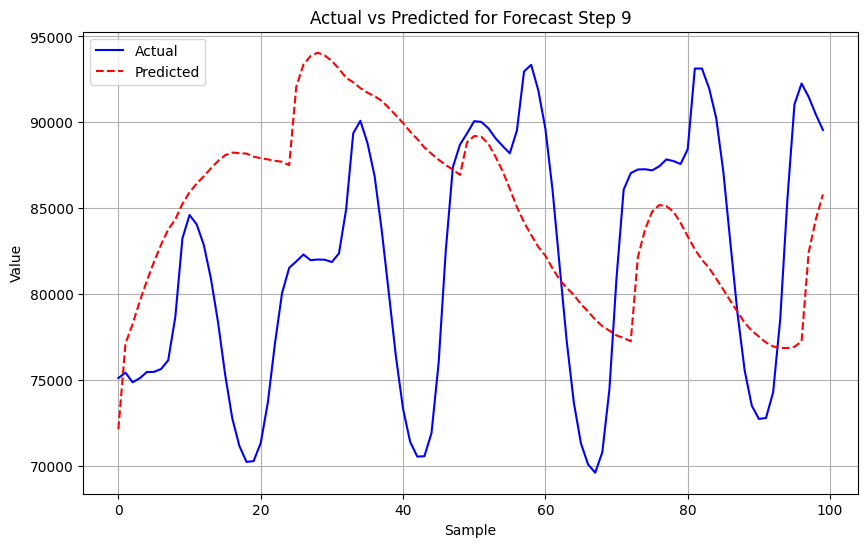

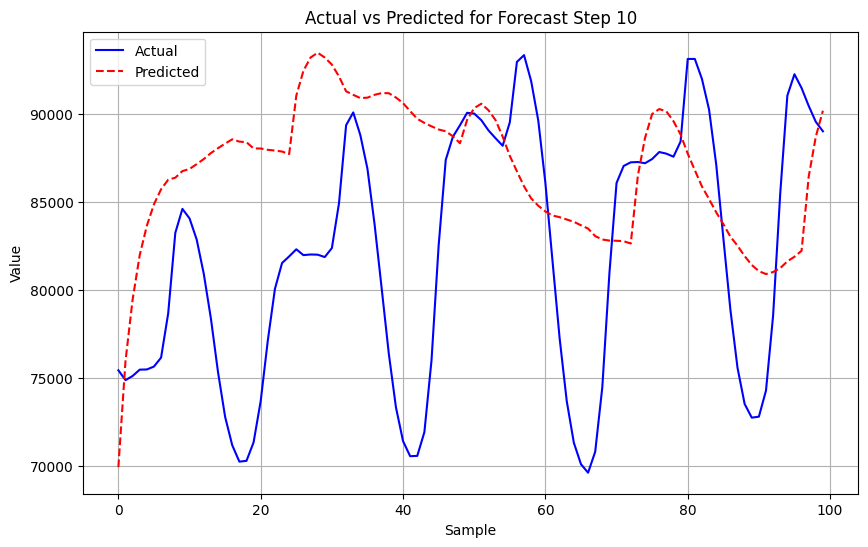

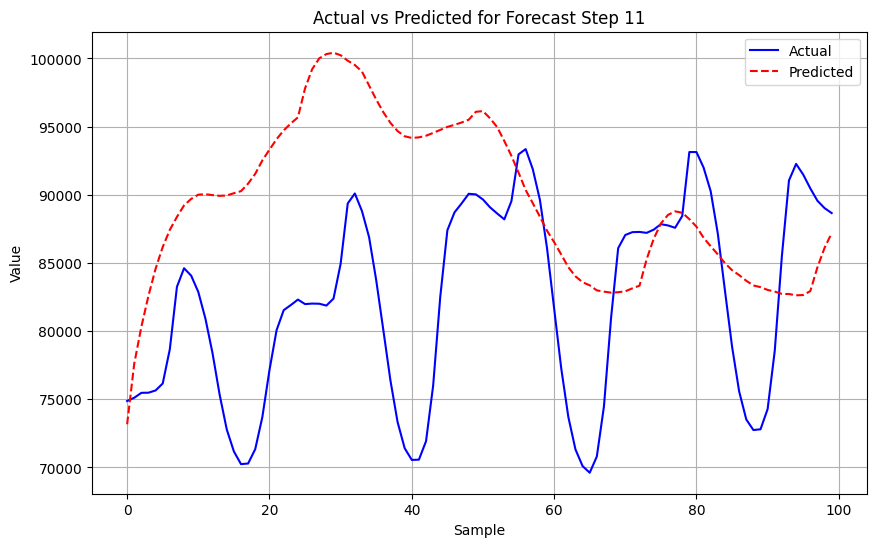

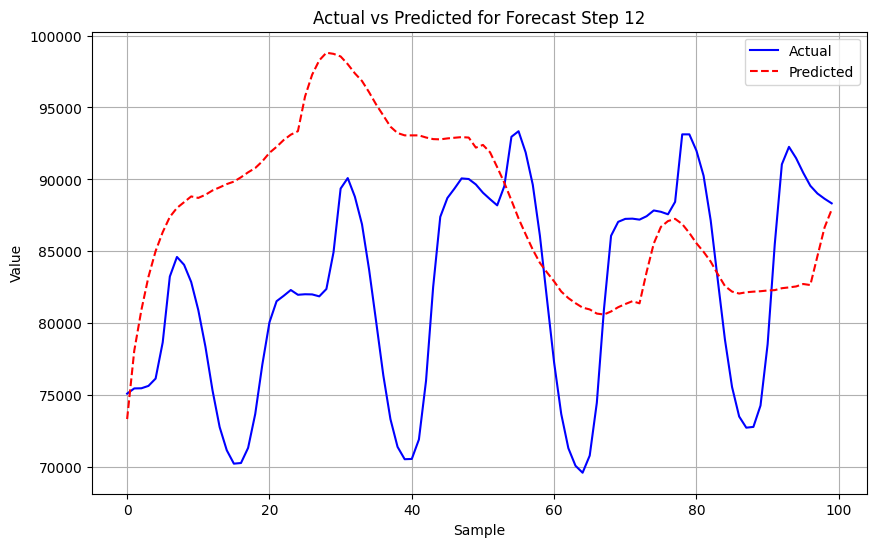

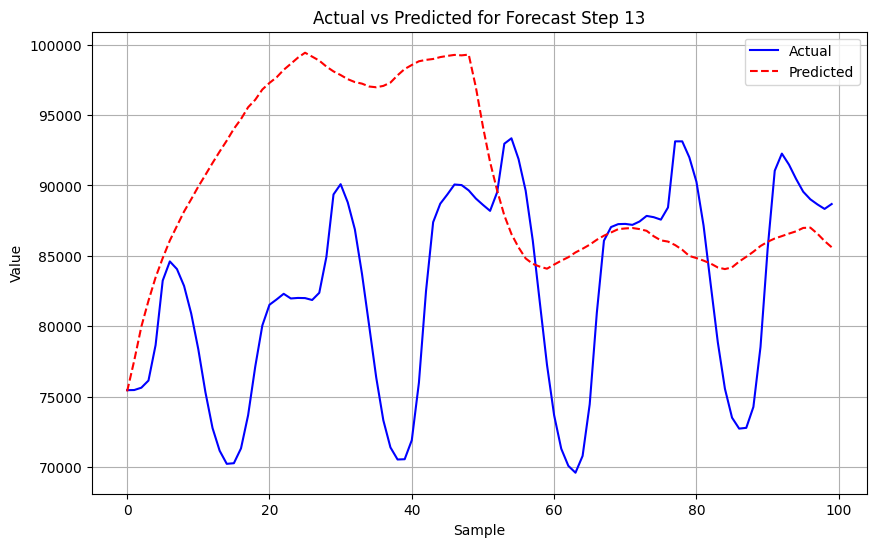

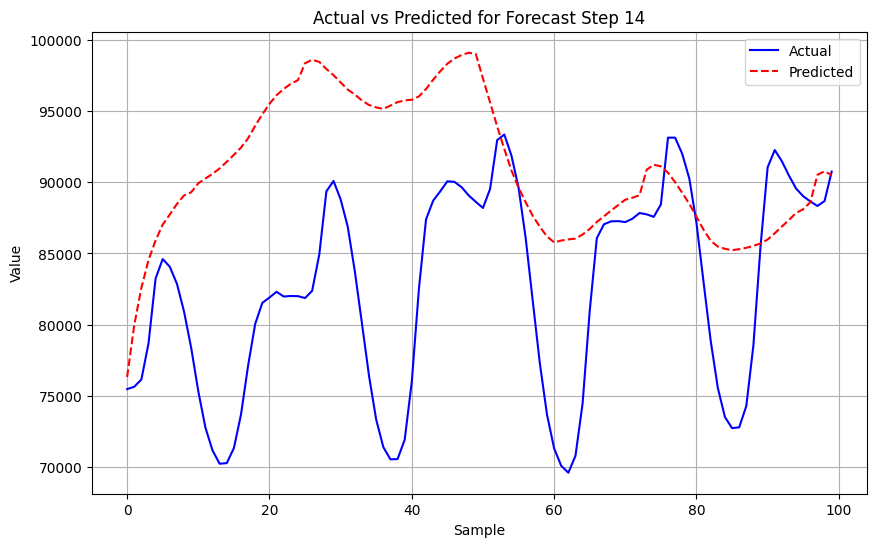

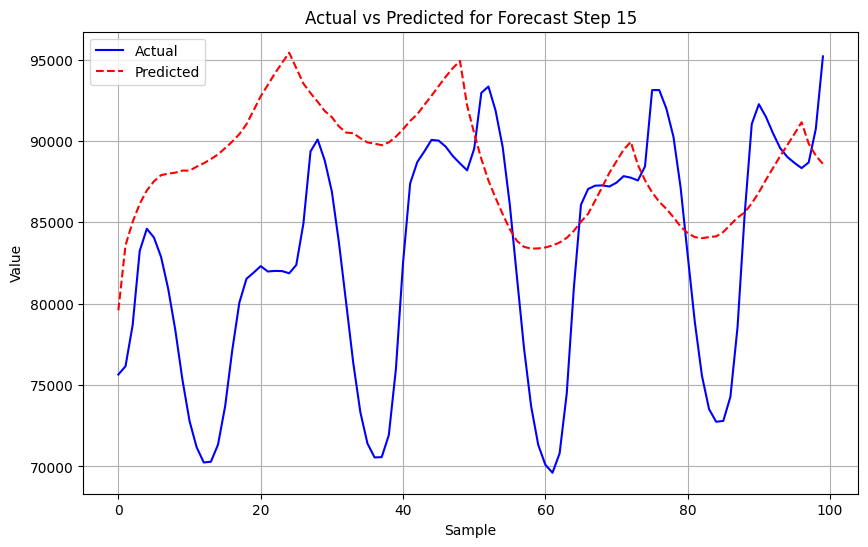

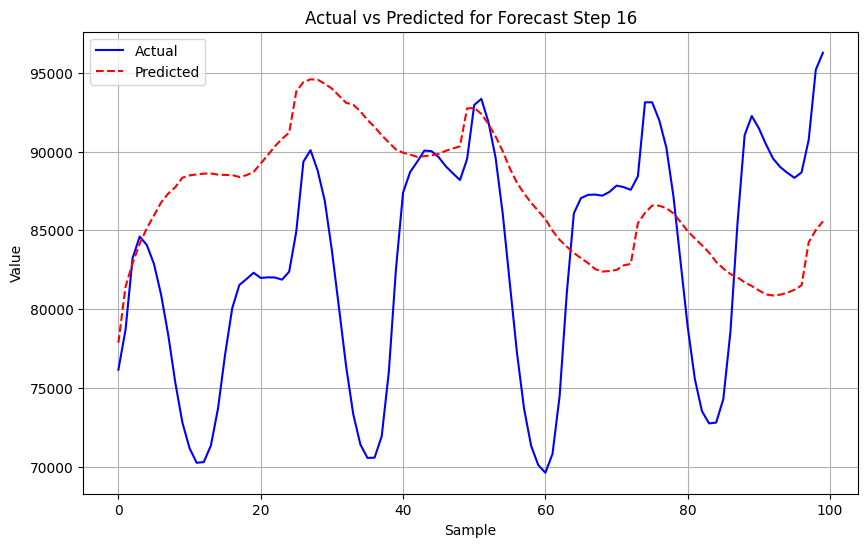

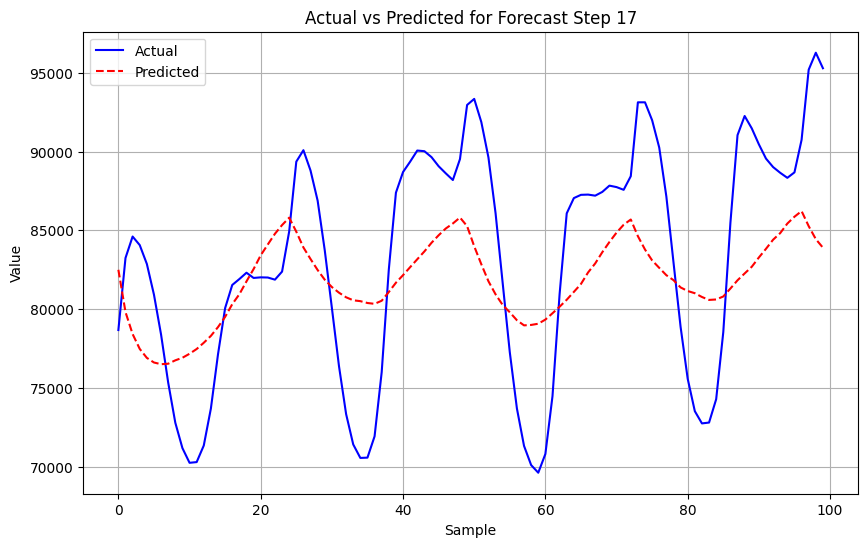

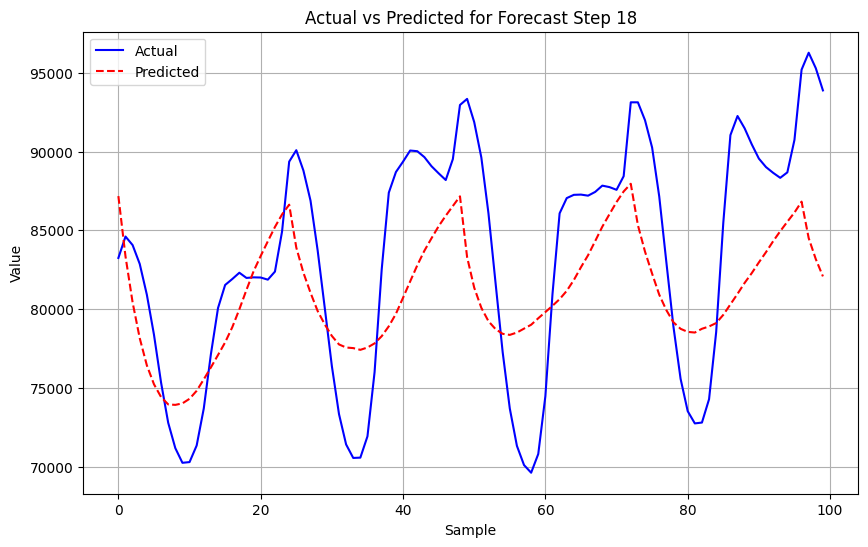

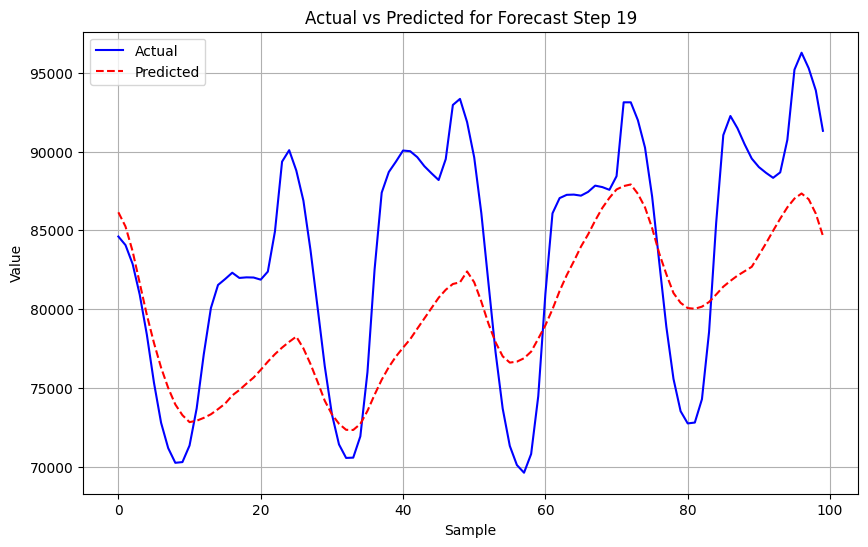

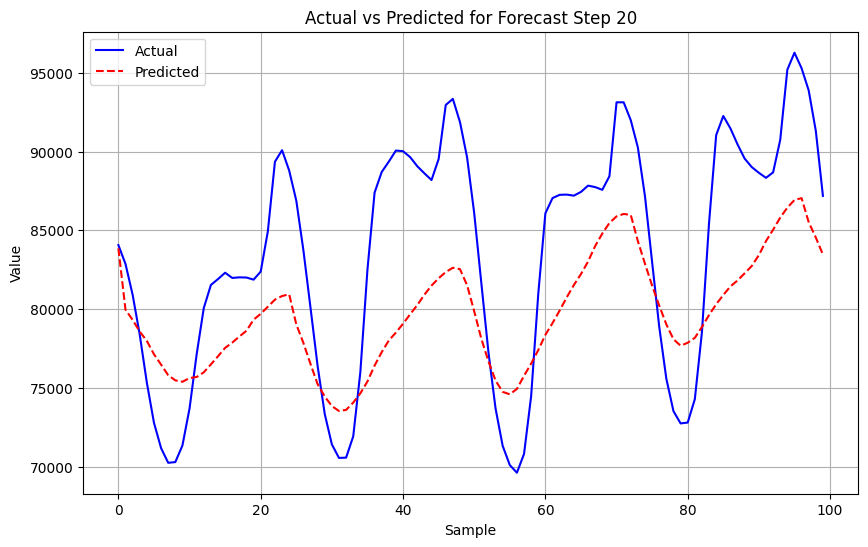

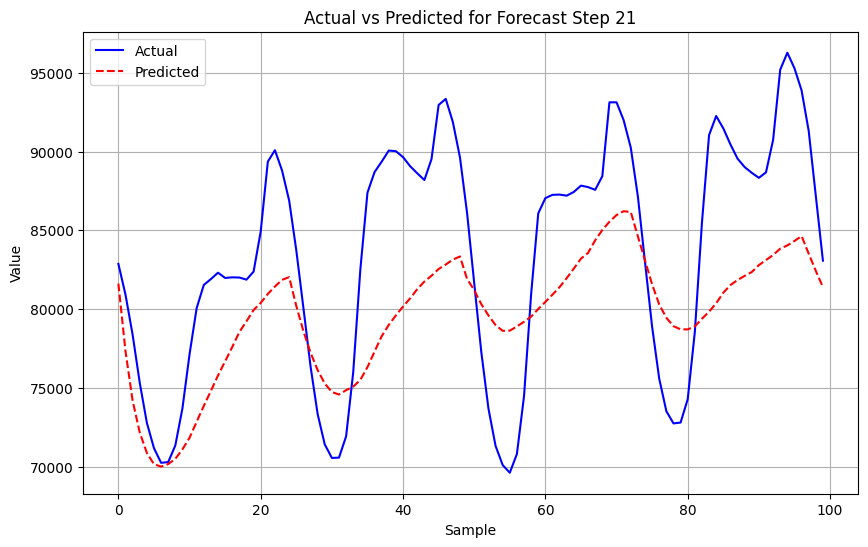

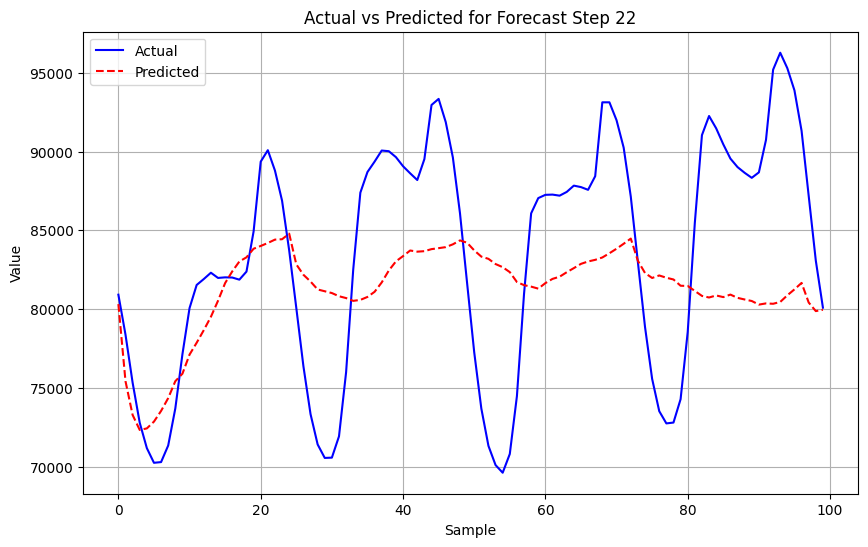

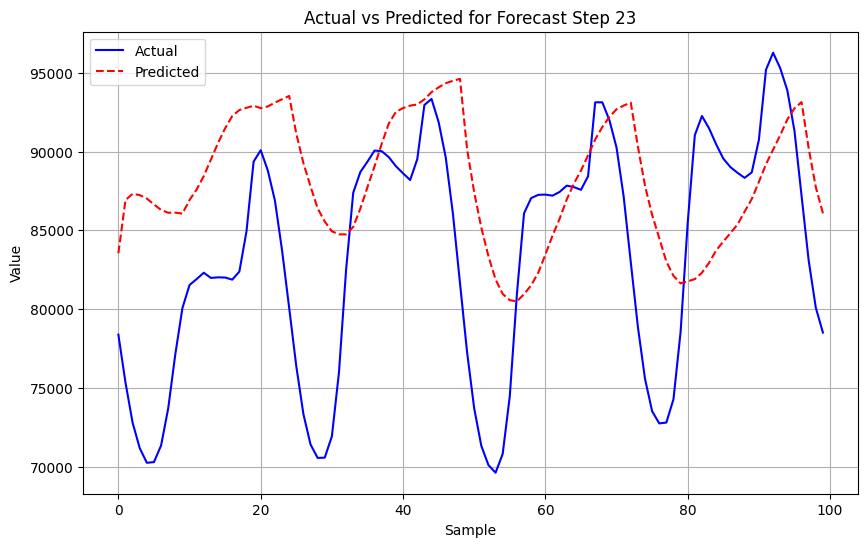

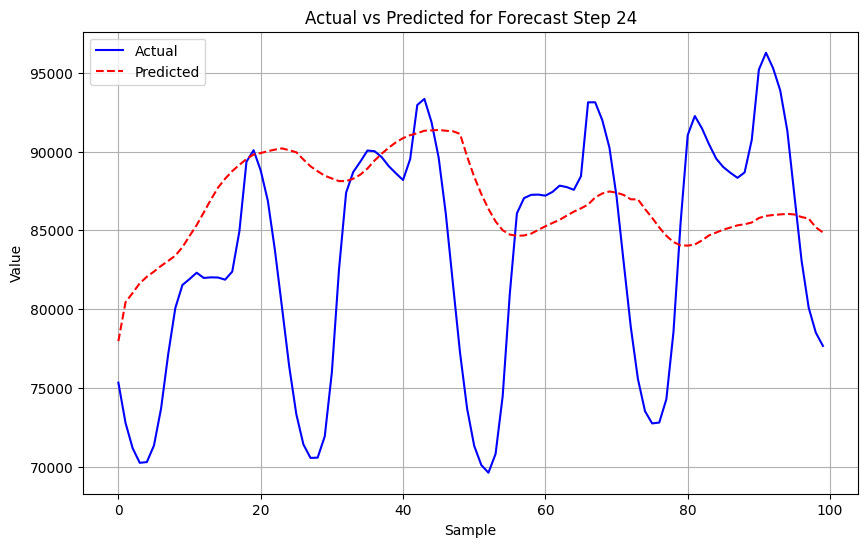

Error for forecast step number 1: rmse :10565.77,mape :9.63, mae :8238.18, r2 :0.46
Error for forecast step number 2: rmse :10315.53,mape :9.20, mae :7944.36, r2 :0.49
Error for forecast step number 3: rmse :10447.33,mape :9.33, mae :7986.31, r2 :0.47
Error for forecast step number 4: rmse :10646.74,mape :9.49, mae :8053.66, r2 :0.45
Error for forecast step number 5: rmse :9922.99,mape :8.78, mae :7546.87, r2 :0.52
Error for forecast step number 6: rmse :10594.20,mape :9.40, mae :8183.97, r2 :0.46
Error for forecast step number 7: rmse :10922.93,mape :9.76, mae :8459.56, r2 :0.42
Error for forecast step number 8: rmse :9841.63,mape :8.87, mae :7751.09, r2 :0.53
Error for forecast step number 9: rmse :9690.27,mape :8.71, mae :7656.72, r2 :0.55
Error for forecast step number 10: rmse :10073.24,mape :9.11, mae :8011.87, r2 :0.51
Error for forecast step number 11: rmse :10232.92,mape :9.09, mae :8100.77, r2 :0.49
Error for forecast step number 12: rmse :10099.04,mape :8.84, mae :7984.56, r

In [22]:

# Split data into training and validation sets
split_idx = int(len(train_X) * 0.8)
val_X, val_y = train_X[split_idx:], train_y[split_idx:]
train_X, train_y = train_X[:split_idx], train_y[:split_idx]

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_weights.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_delta=0.001, cooldown=0, min_lr=1e-5)

# Design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='Adam')

# Fit network
history = model.fit(train_X, train_y, epochs=400, batch_size=512,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], validation_data=(val_X, val_y), verbose=1, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


# make a prediction
yhat = model.predict(test_X)

def invert_scaling_multistep(predictions, scaler, feature_index):
    """
    Invert the scaling for a multistep prediction.

    predictions: The predicted values to invert.
    scaler: The scaler object that was originally fitted to the dataset.
    feature_index: The index of the feature in the original dataset that you're predicting.
    """
    # Extract the min and scale values for the feature of interest from the scaler
    min_val = scaler.data_min_[feature_index]
    scale = scaler.scale_[feature_index]

    # Invert the scaling
    inverted = predictions / scale + min_val
    return inverted
feature_index = 0
yhat_original = invert_scaling_multistep(yhat, scaler, feature_index)
test_y_original = invert_scaling_multistep(test_y, scaler, feature_index)

rmse = sqrt(mean_squared_error(test_y_original, yhat_original))
mape = 100*mean_absolute_percentage_error(test_y_original, yhat_original)
mae = mean_absolute_error(test_y_original, yhat_original)
r2 = r2_score(test_y_original, yhat_original)

print('Test mape: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)
print('Test mae: %.3f' % mae)
print('Test r2: %.3f' % r2)





maes = []
rmses = []
mapes = []
r2s = []
# Loop through each forecast step
for i in range(horizon):
    mae = mean_absolute_error(test_y_original[:, i], yhat_original[:, i])
    rmse = sqrt(mean_squared_error(test_y_original[:, i], yhat_original[:, i]))
    mape = 100*mean_absolute_percentage_error(test_y_original[:, i], yhat_original[:, i])
    r2 = r2_score(test_y_original[:, i], yhat_original[:, i])
    maes.append(mae)
    rmses.append(rmse)
    mapes.append(mape)
    r2s.append(r2)
    print(f"Error for forecast step number {i+1}: rmse :{rmse:.2f},mape :{mape:.2f}, mae :{mae:.2f}, r2 :{r2:.2f}")

from sklearn.metrics import precision_score, recall_score

# Convert test_y_original and yhat_original to DataFrames
test_y_original_df = pd.DataFrame(test_y_original)
yhat_original_df = pd.DataFrame(yhat_original)

n_steps = test_y_original_df.shape[1]

forecast_steps = [i+1 for i in range(horizon)]

# Plot MAE
plt.figure()
plt.plot(forecast_steps, maes, marker='o', label='MAE')
plt.title('Mean Absolute Error for Each Forecast Step')
plt.xlabel('Forecast Step')
plt.ylabel('Error')
plt.grid(True)
plt.legend()
plt.show()

# Plot RMSE
plt.figure()
plt.plot(forecast_steps, rmses, marker='o', label='RMSE')
plt.title('Root Mean Squared Error for Each Forecast Step')
plt.xlabel('Forecast Step')
plt.ylabel('Error')
plt.grid(True)
plt.legend()
plt.show()

# Plot SMAPE
plt.figure()
plt.plot(forecast_steps, mapes, marker='o', label='MAPE')
plt.title('Mean Absolute Percentage Error for Each Forecast Step')
plt.xlabel('Forecast Step')
plt.ylabel('Error (%)')
plt.grid(True)
plt.legend()
plt.show()

# Plot R^2
plt.figure()
plt.plot(forecast_steps, r2s, marker='o', label='R^2')
plt.title('R^2 Score for Each Forecast Step')
plt.xlabel('Forecast Step')
plt.ylabel('R^2 Score')
plt.grid(True)
plt.legend()
plt.show()

'''
visualization
'''

num_samples = 100

for i in range(horizon):
    plt.figure(figsize=(10, 6))
    plt.plot(test_y_original[:num_samples, i], label='Actual', color='blue')
    plt.plot(yhat_original[:num_samples, i], label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted for Forecast Step {i+1}')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


maes = []
rmses = []
mapes = []
r2s = []
# Loop through each forecast step
for i in range(horizon):
    mae = mean_absolute_error(test_y_original[:, i], yhat_original[:, i])
    rmse = sqrt(mean_squared_error(test_y_original[:, i], yhat_original[:, i]))
    mape = 100*mean_absolute_percentage_error(test_y_original[:, i], yhat_original[:, i])
    r2 = r2_score(test_y_original[:, i], yhat_original[:, i])
    maes.append(mae)
    rmses.append(rmse)
    mapes.append(mape)
    r2s.append(r2)
    print(f"Error for forecast step number {i+1}: rmse :{rmse:.2f},mape :{mape:.2f}, mae :{mae:.2f}, r2 :{r2:.2f}")